In [257]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)
sns.set_palette('flare')

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [259]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [260]:
df = pd.read_csv("../data/restaurant_01_ts.csv", index_col=0, parse_dates=[0])
df.index.freq = 'D'
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1513 entries, 2019-06-10 to 2023-07-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Orders  1497 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


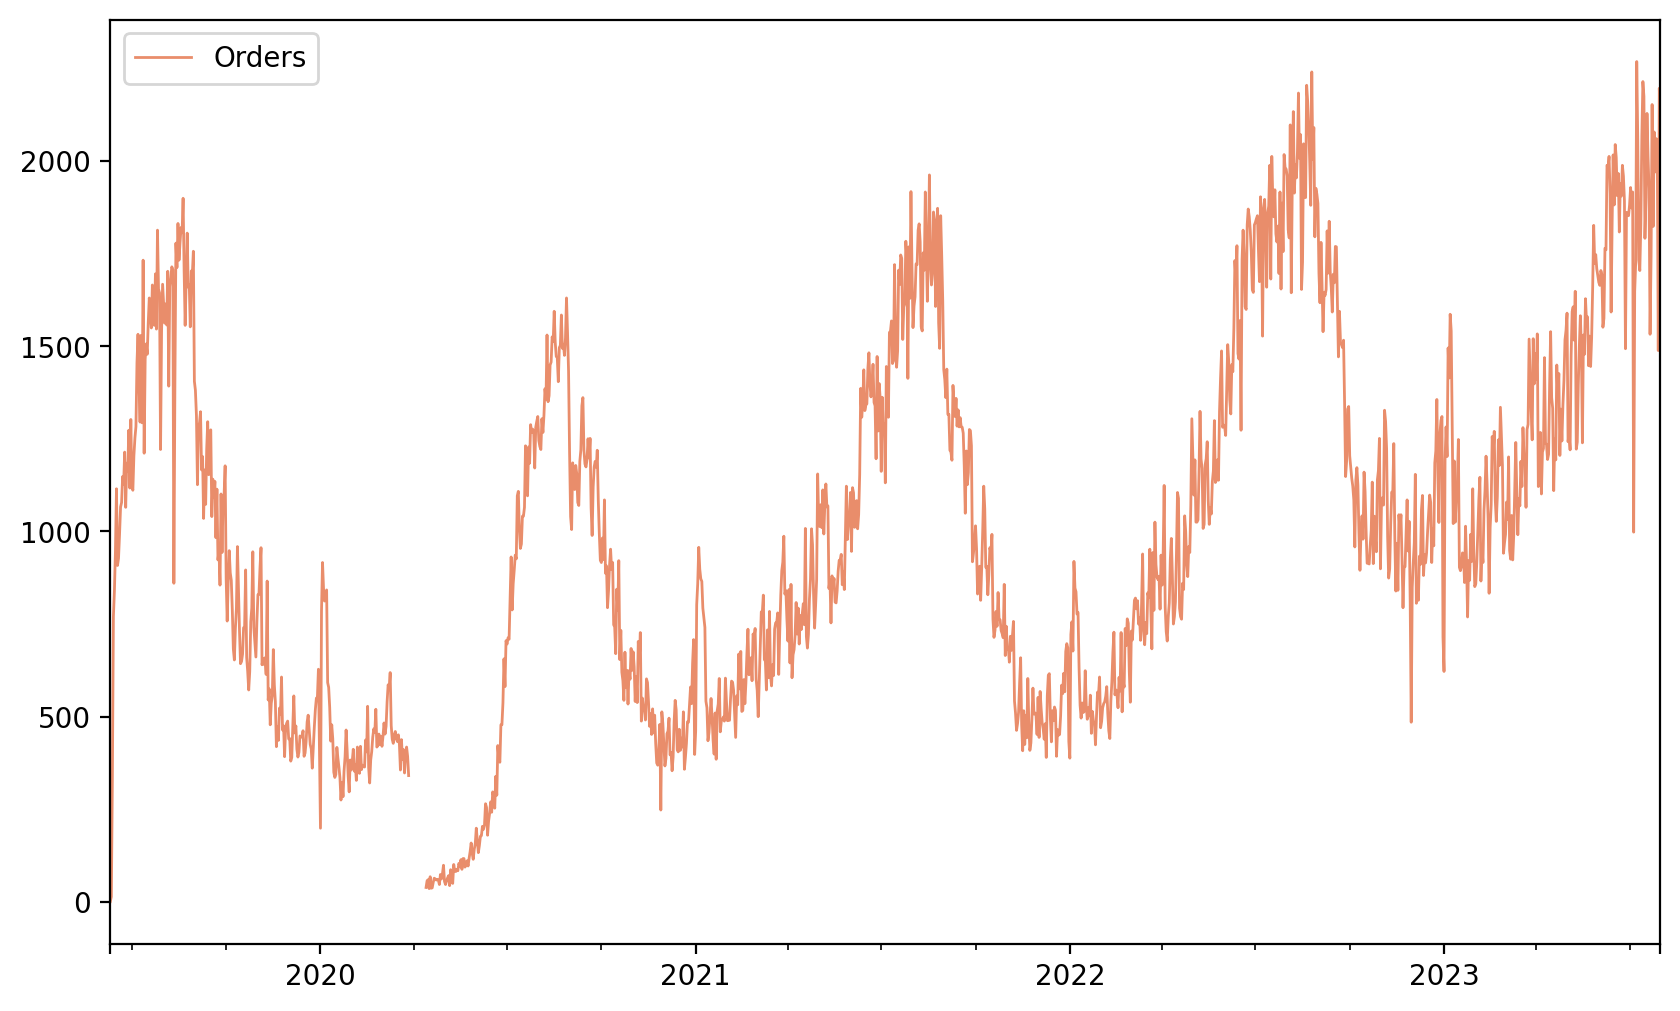

In [262]:
ax = df.plot(figsize=(10, 6), linewidth=1)
plt.show()

Сохраняю индексы мест где пропуски

In [263]:
na = df.isna().any(axis=1)
na_ind = na[na].index

Заполняю пропуски линейной интерполяцией

In [264]:
df["Orders"].interpolate(method="linear", inplace=True)

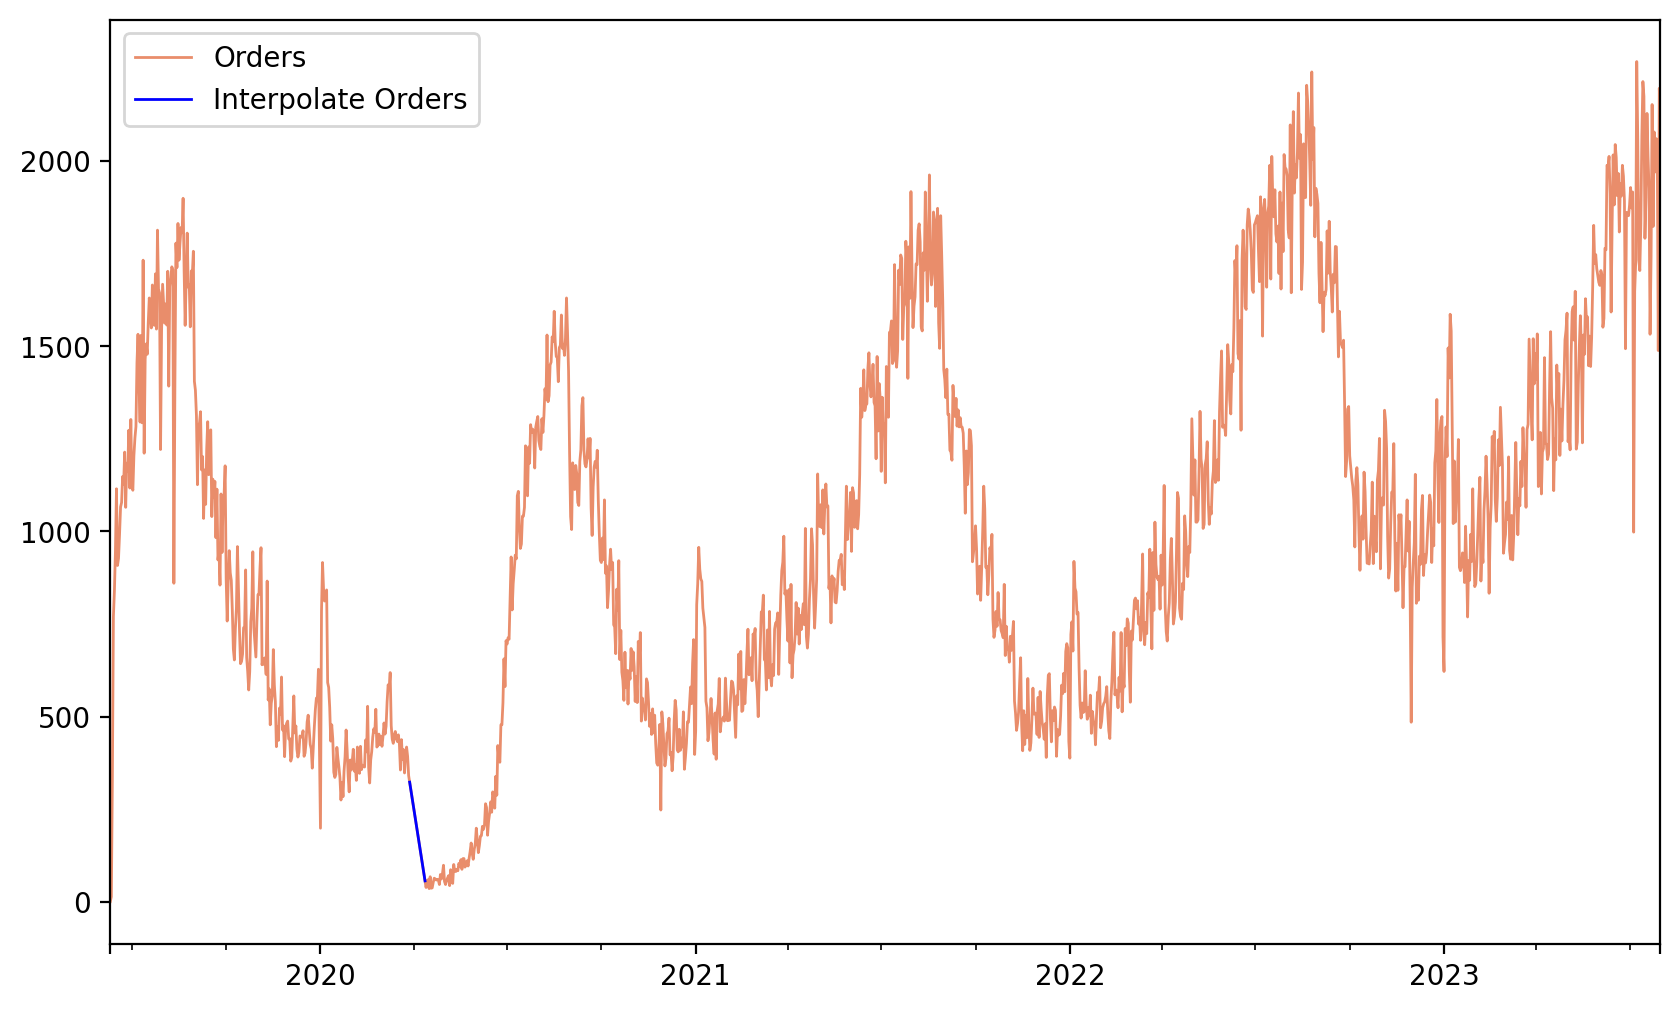

In [265]:
ax = df.plot(y="Orders", figsize=(10, 6), linewidth=1)
df.loc[na_ind].plot(y="Orders", linewidth=1, color="blue", ax=ax)
ax.legend(["Orders", "Interpolate Orders"])
plt.show()

### Распределени временного ряда
поиск выбросов

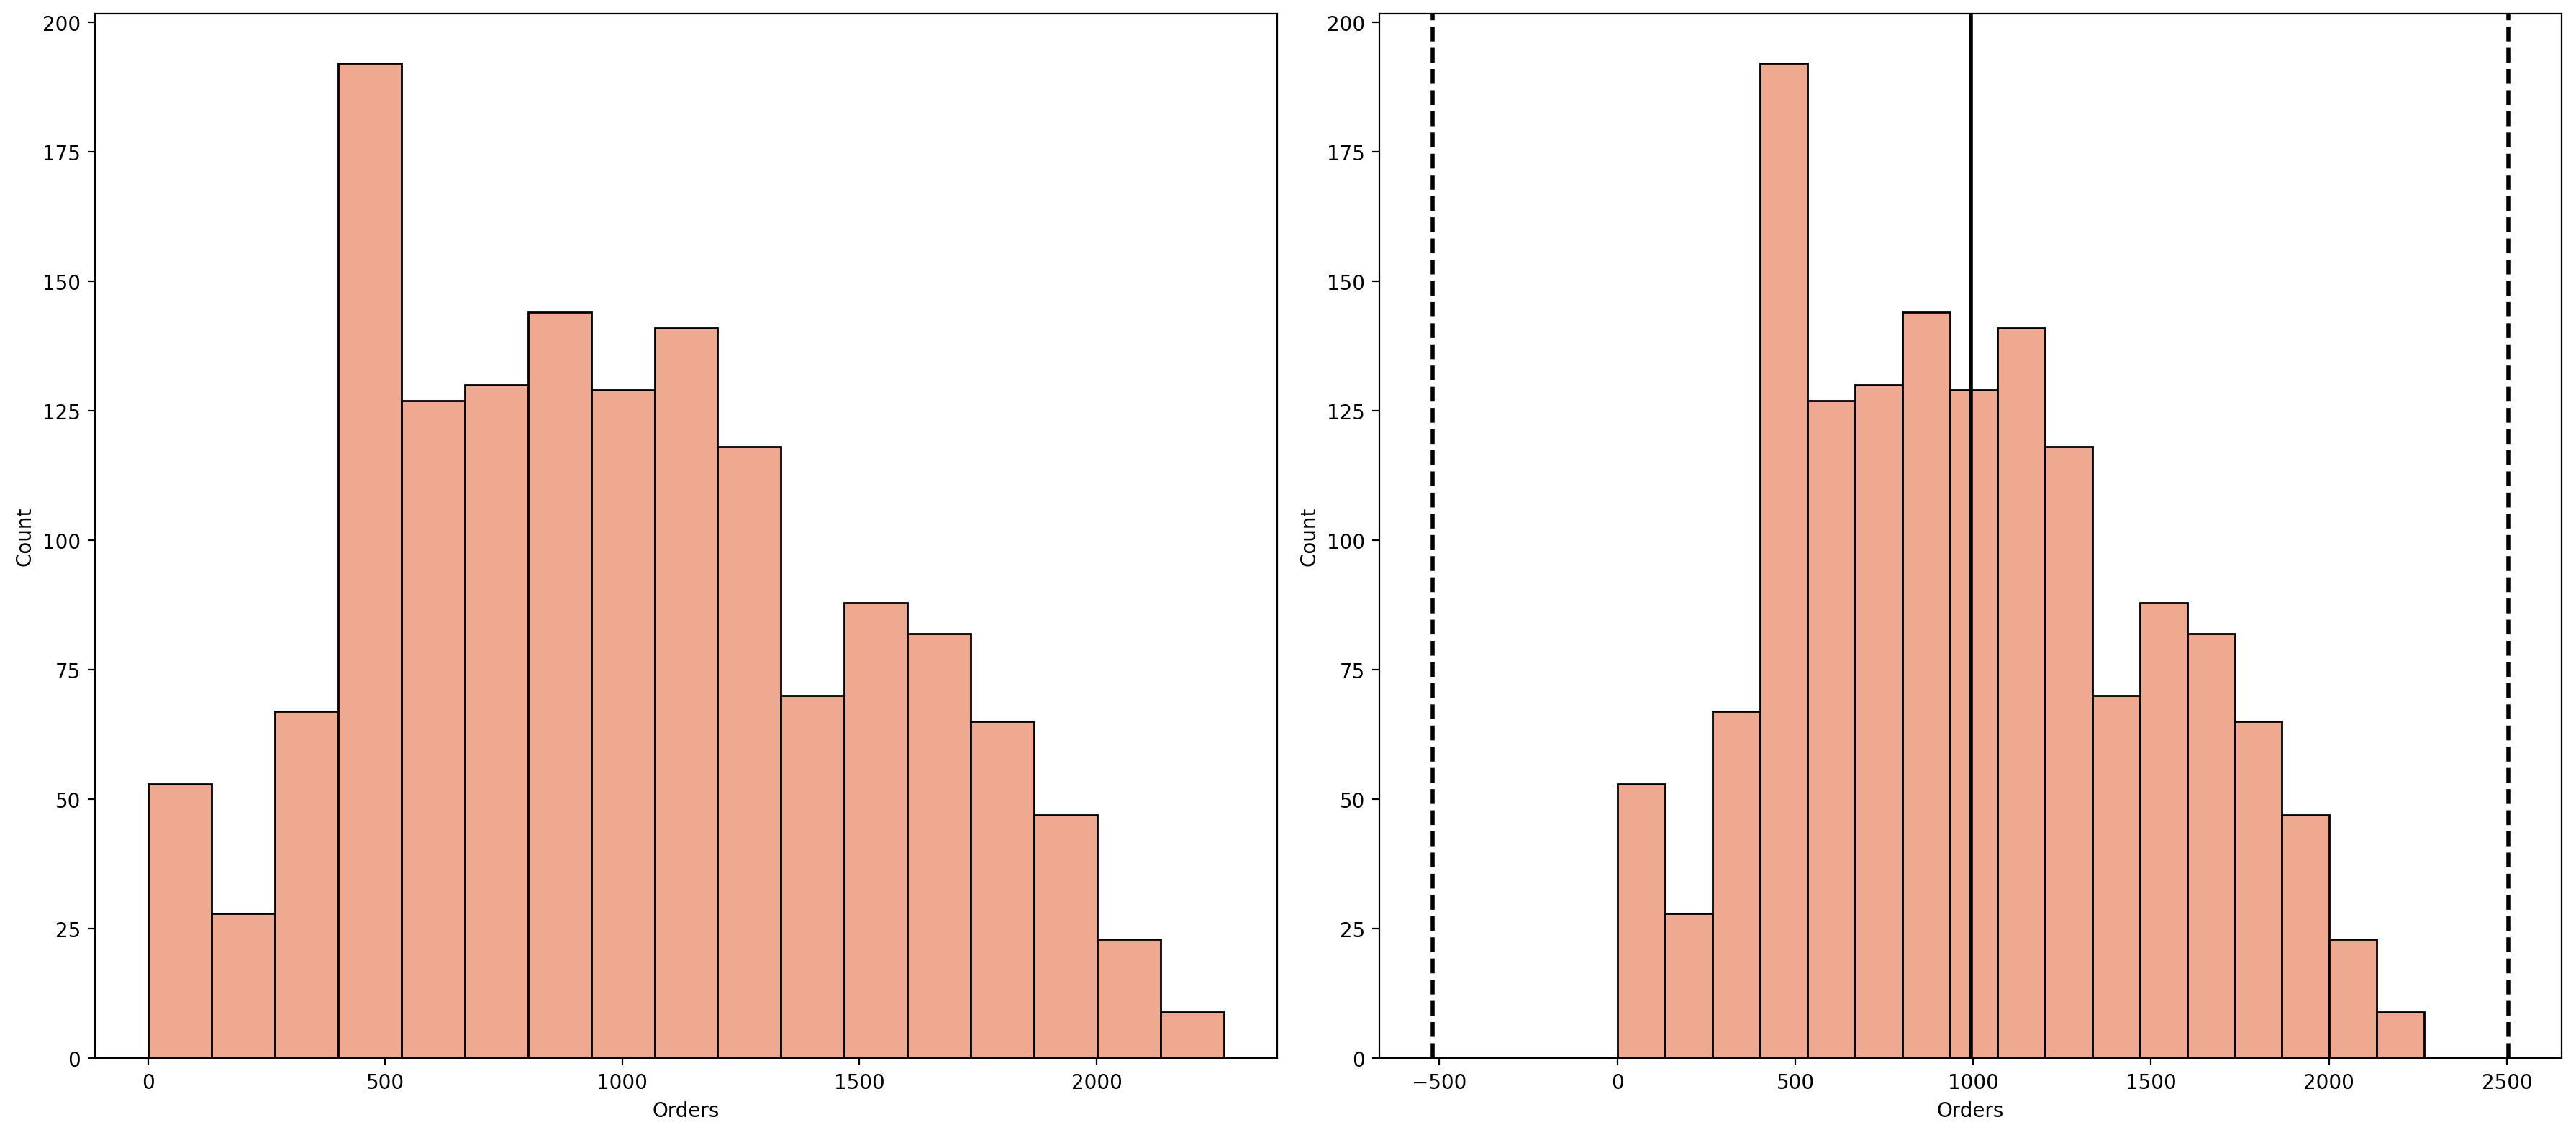

In [266]:
hd.plot_outliers_z_score(df, "Orders")

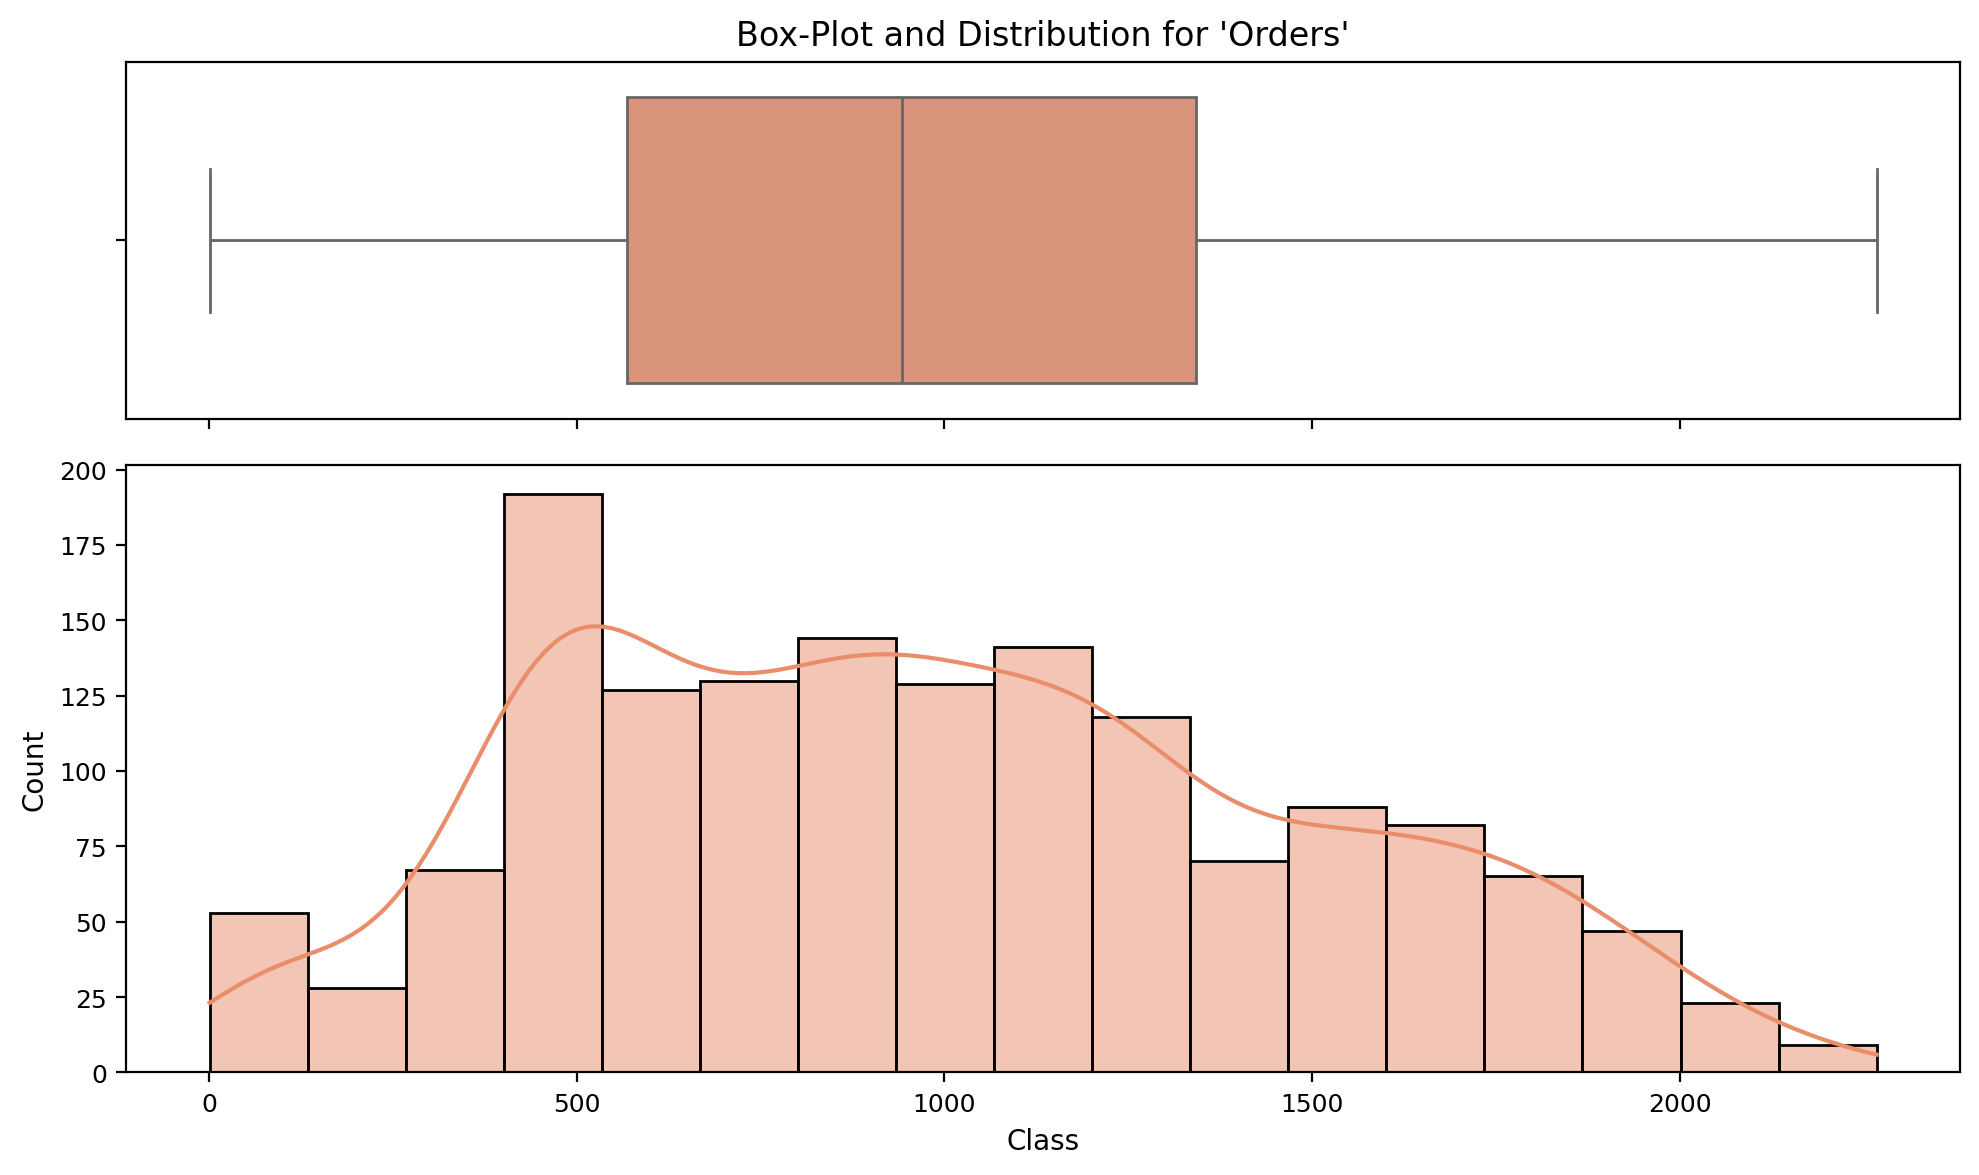

In [267]:
hd.box_and_hist_plots(df, "Orders")

Я не вижу явных выбросов, которые необходимо было бы обрабатывать.

### Произвожу декомпозицию

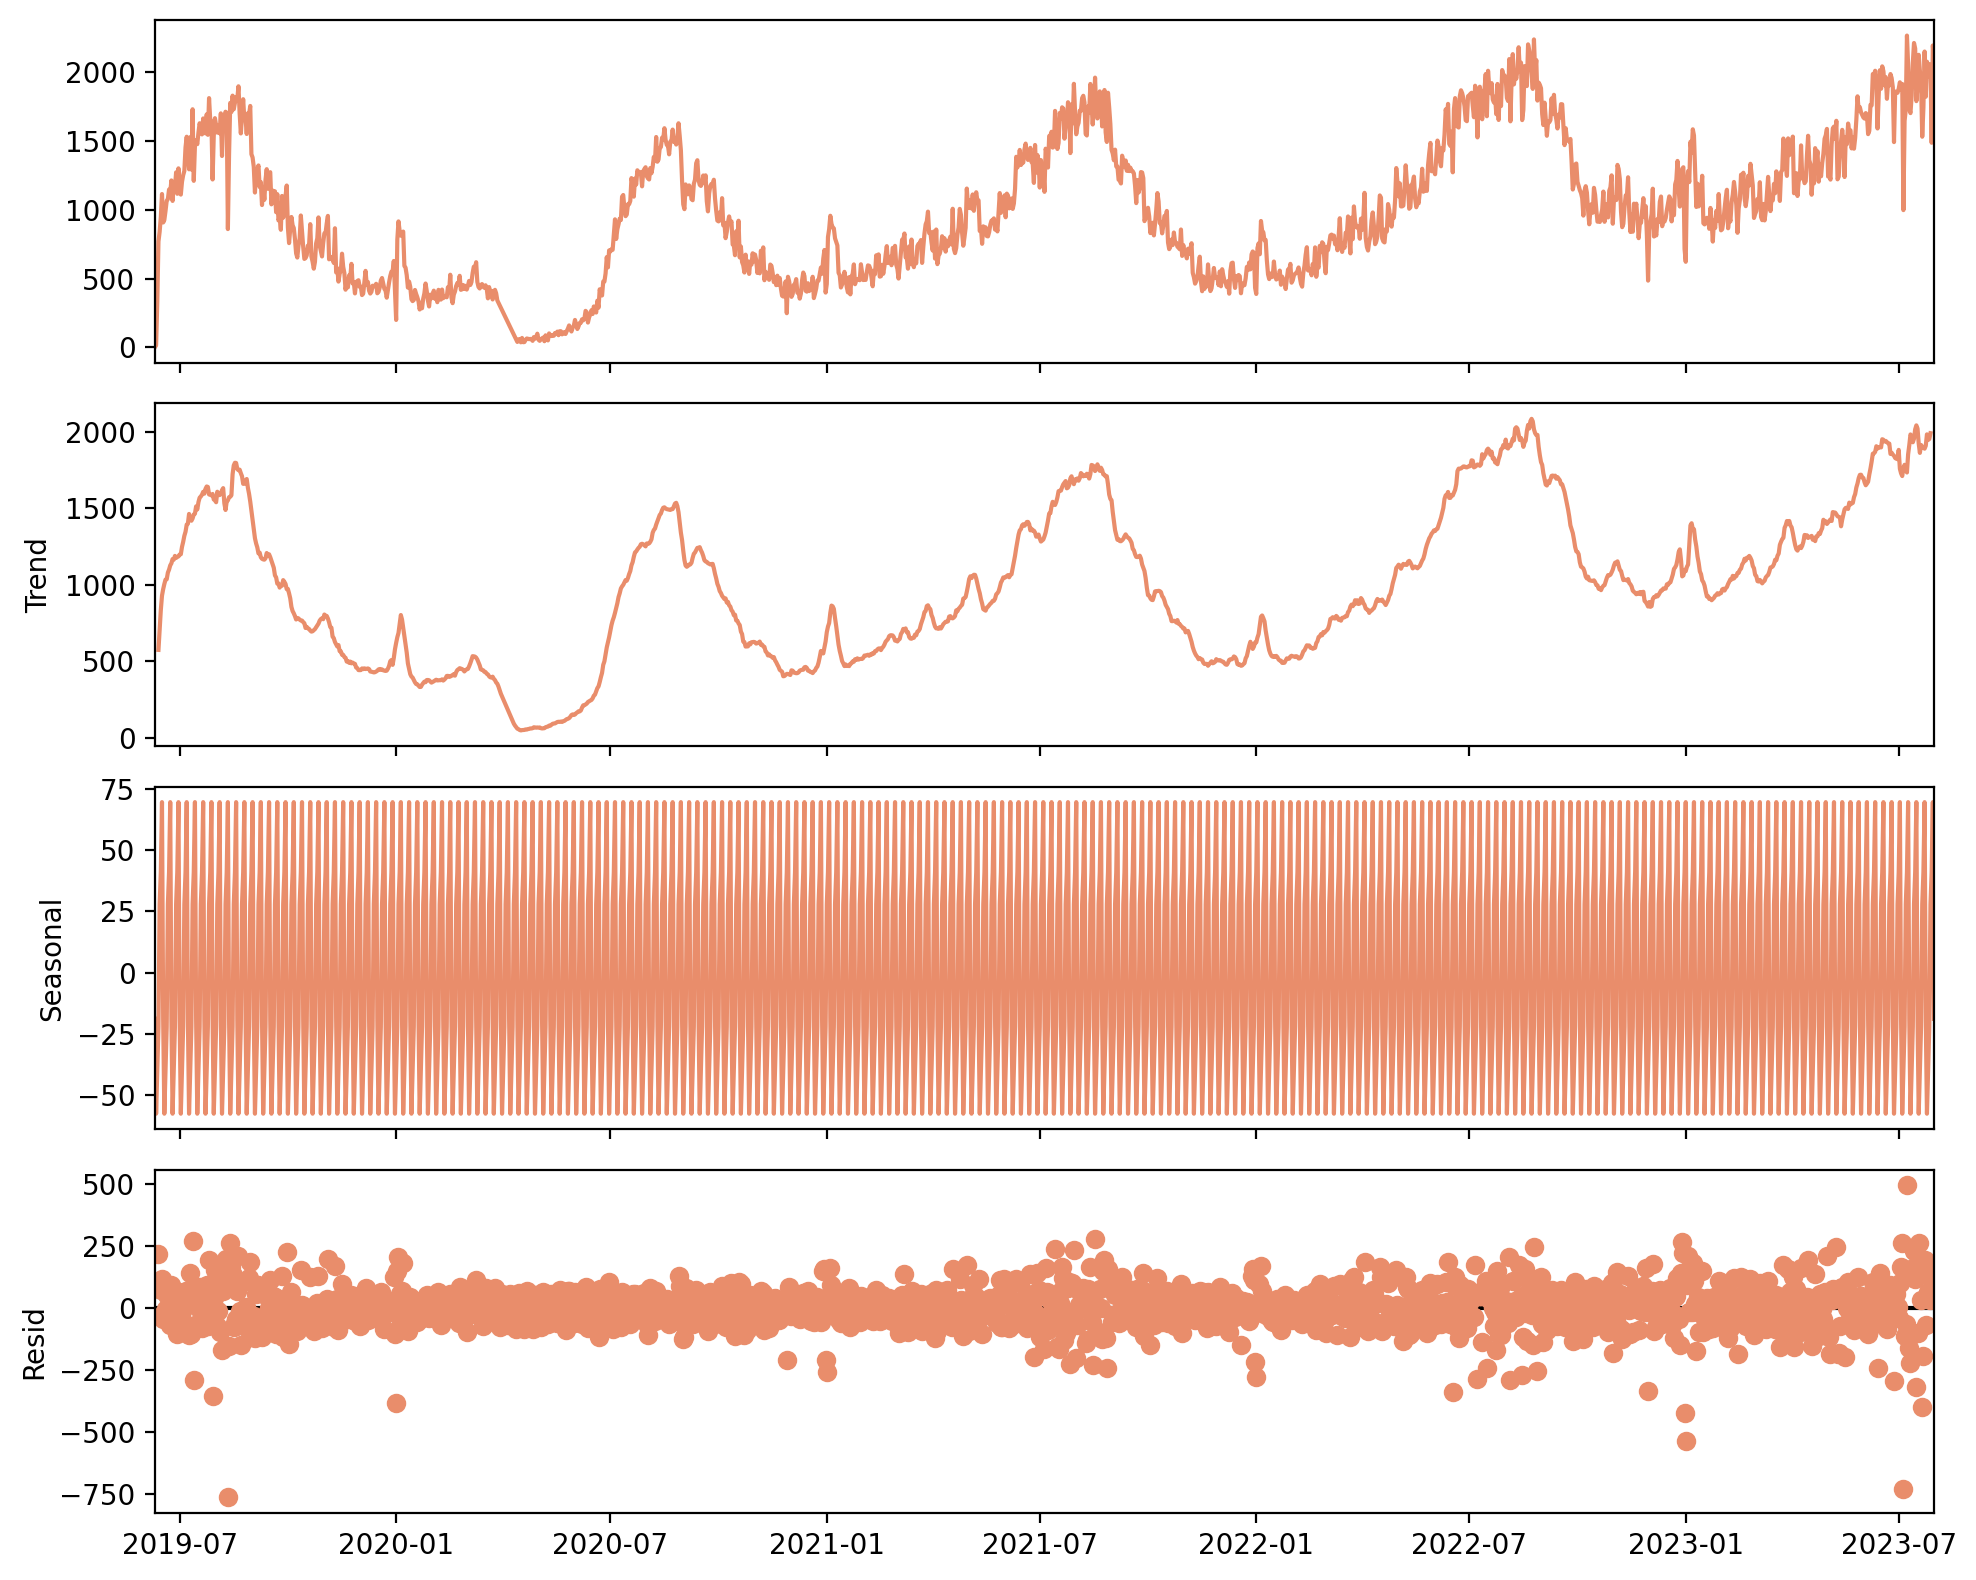

In [268]:
decomposition = seasonal_decompose(df, model="additive")
decomposition.plot()
plt.show()

Рассматриваю сезонную компоненту

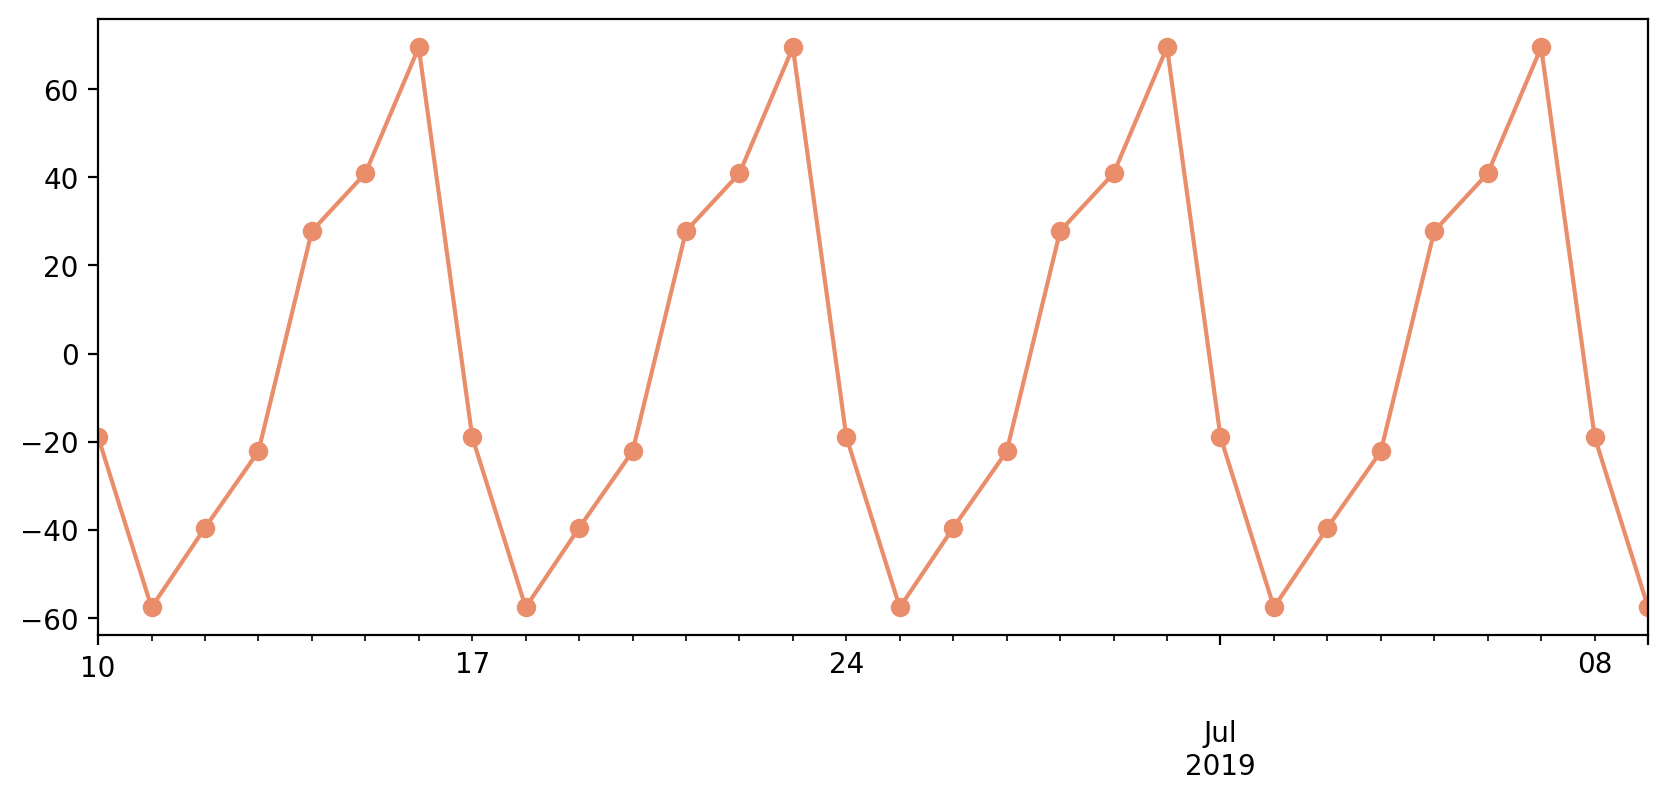

In [269]:
plt.figure(figsize=(10, 4))
decomposition.seasonal[:30].plot(marker="o")
plt.show()

График четко показывает 7 дневный (недельный) цикл сезонности. m = 7

In [270]:
m = 7

### Проверка стационарности

In [271]:
hd.adf(df["Orders"])

Test-Statistic: -2.2052031459620305
P-Value: 0.2043624379521179
Time series is non-stationary


Ряд не стационарен, дифференцирую и проверяю на стационарность

In [272]:
diff_orders = df["Orders"].diff().dropna()
hd.adf(diff_orders)

Test-Statistic: -6.746702293136594
P-Value: 3.022296637235943e-09
Time series is stationary!


Ряд стал стационарным после первого дифференцирования, значение d = 1

In [273]:
d = 1

### Изучаю коррелограммы
по дифференцированному ряду

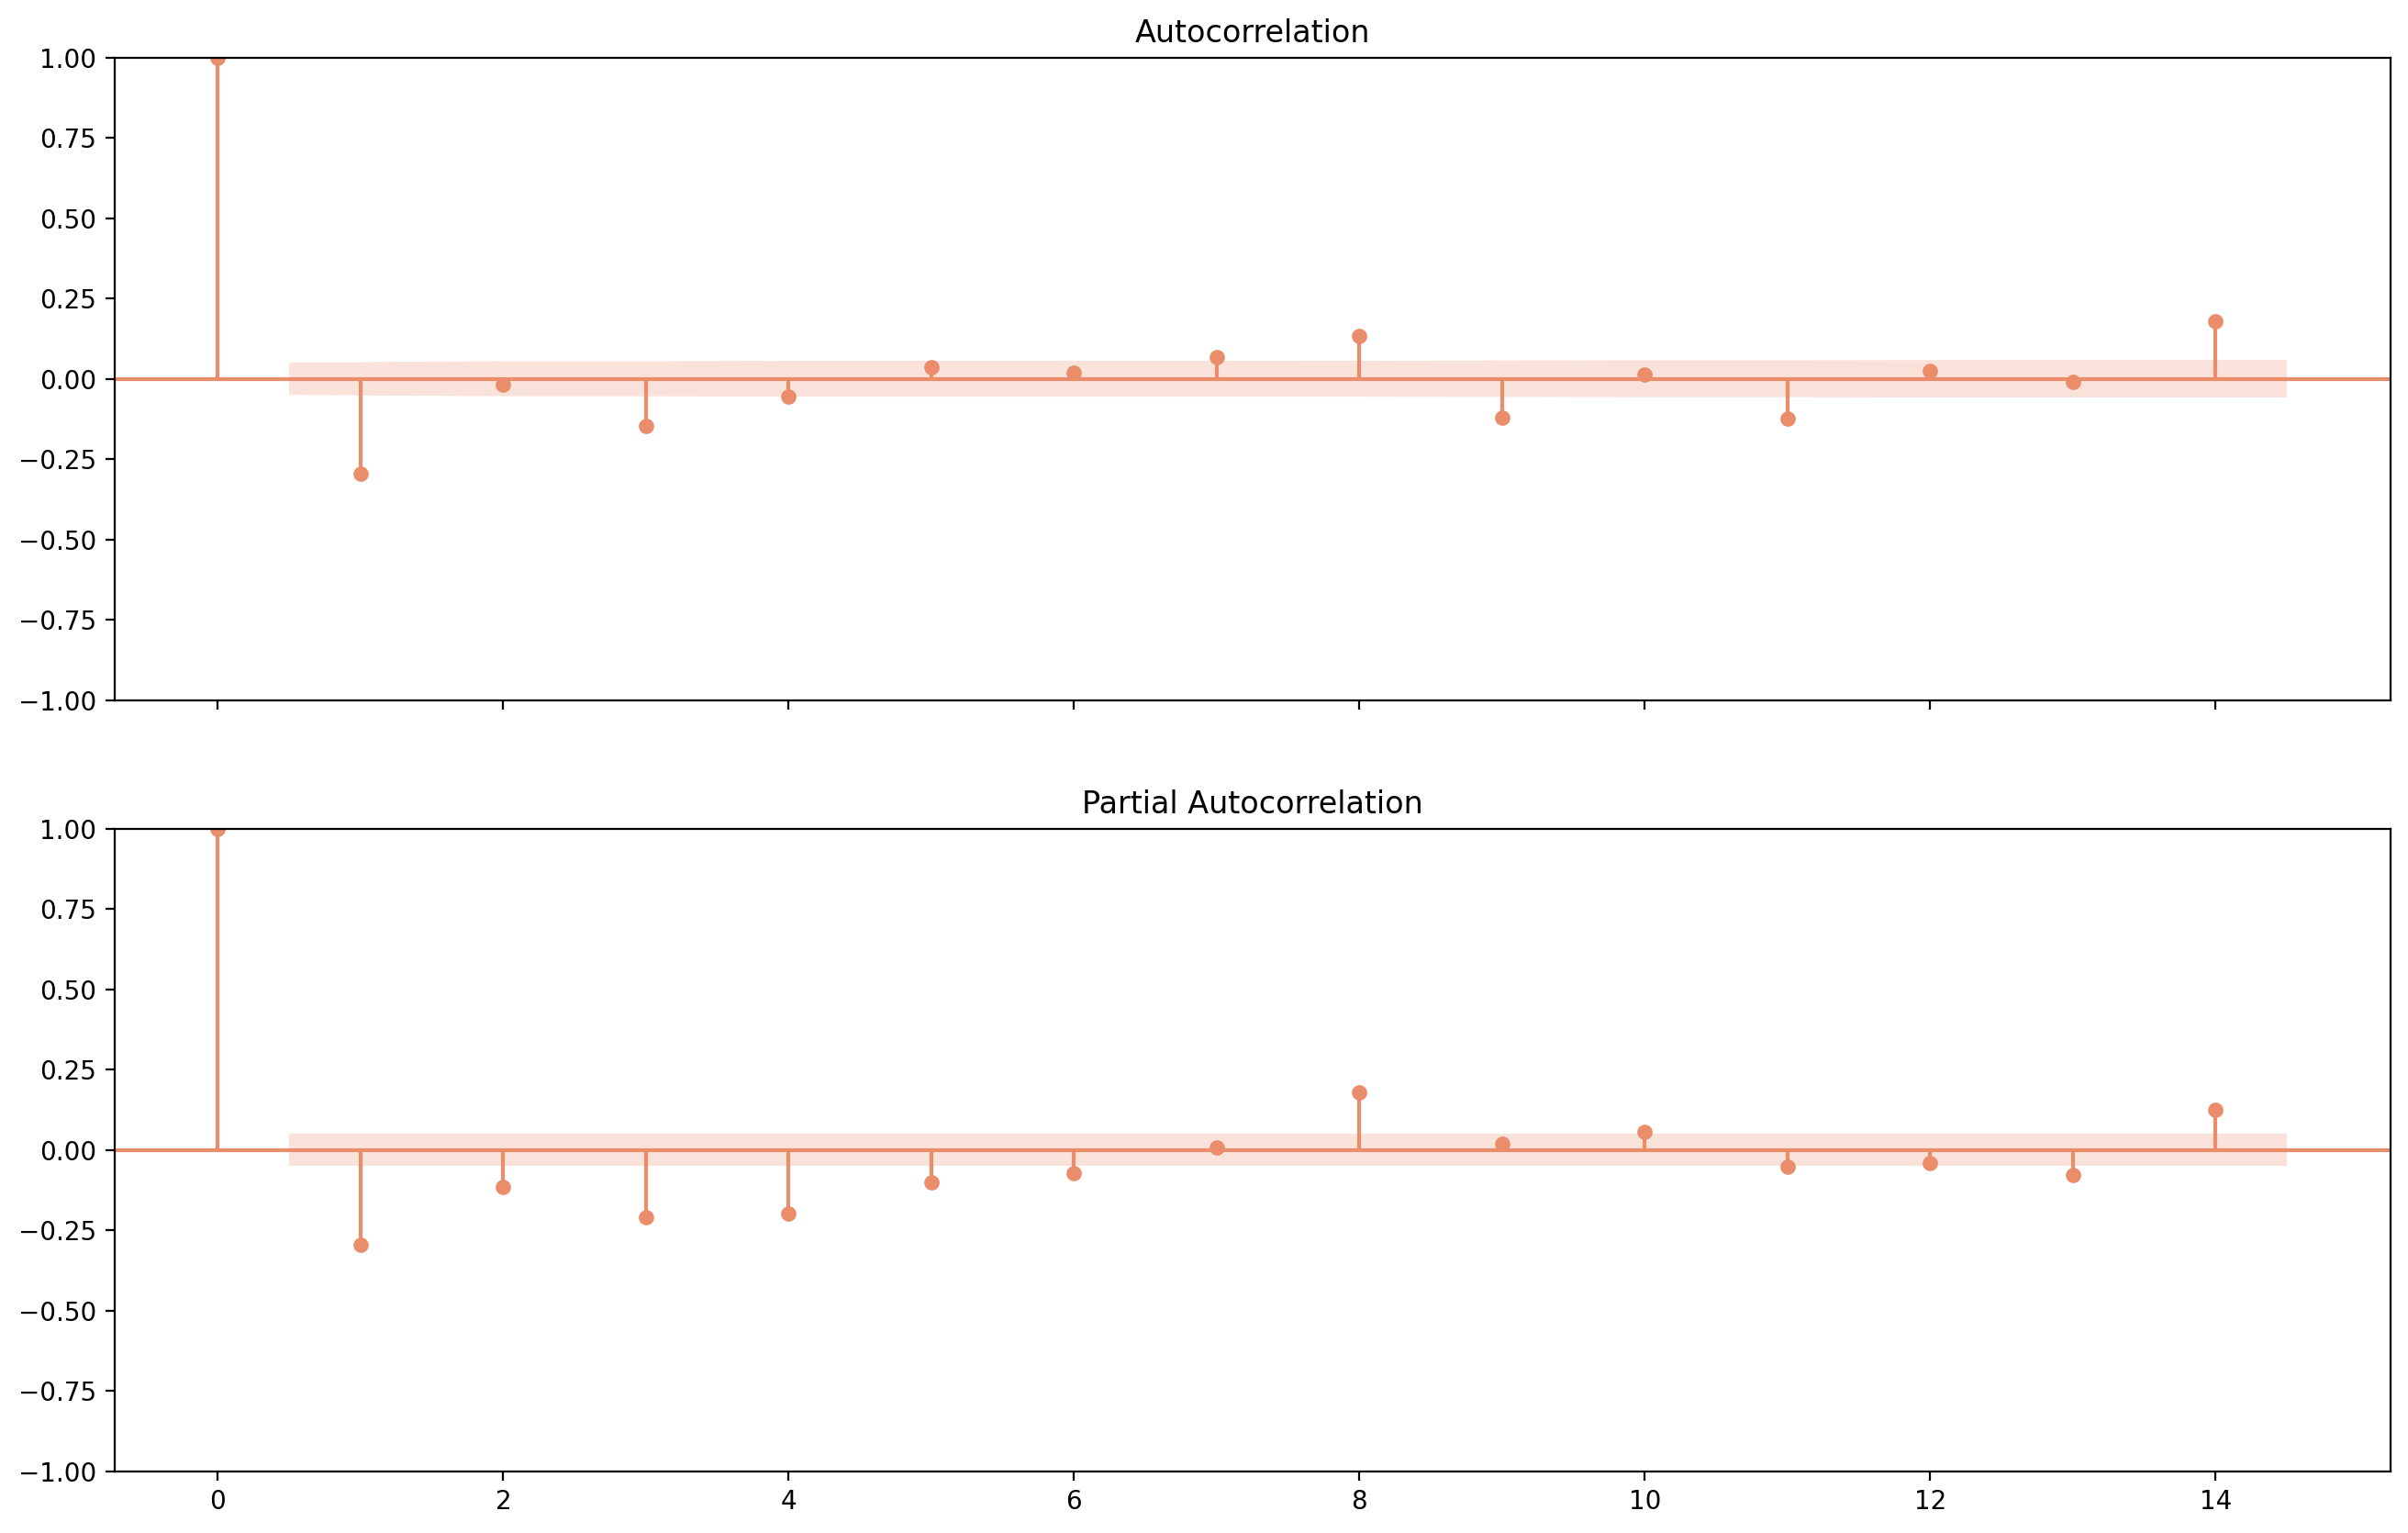

In [251]:
lags = 14
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(diff_orders, lags=lags, ax=ax[0])
plot_pacf(diff_orders, lags=lags, ax=ax[1])
plt.show()

Использую следующую эвристику: Обычно, мы ищем тот лаг, при котором ACF/PACF пересекает верхний или нижний доверительный интервал для первый раз.

Ввыбираю следующие значения. q = 2, p = 7

In [252]:
q = 2
p = 7

### Разделение выборки

In [288]:
test_period = 60 # последний месяц оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

In [289]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['Orders'], order=(p, d, q))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Orders   No. Observations:                 1453
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -8856.716
Date:                Sun, 08 Oct 2023   AIC                          17733.431
Time:                        13:39:44   BIC                          17786.238
Sample:                    06-10-2019   HQIC                         17753.136
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.061    -14.874      0.000      -1.020      -0.783
ar.L2          0.1259      0.019      6.677      0.000       0.089       0.163
ar.L3         -0.5874      0.021    -27.525      0.0

In [290]:
pred_df = pd.DataFrame(index=df.index)
pred_df['Orders'] = df['Orders']
pred_df['arima_v1_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

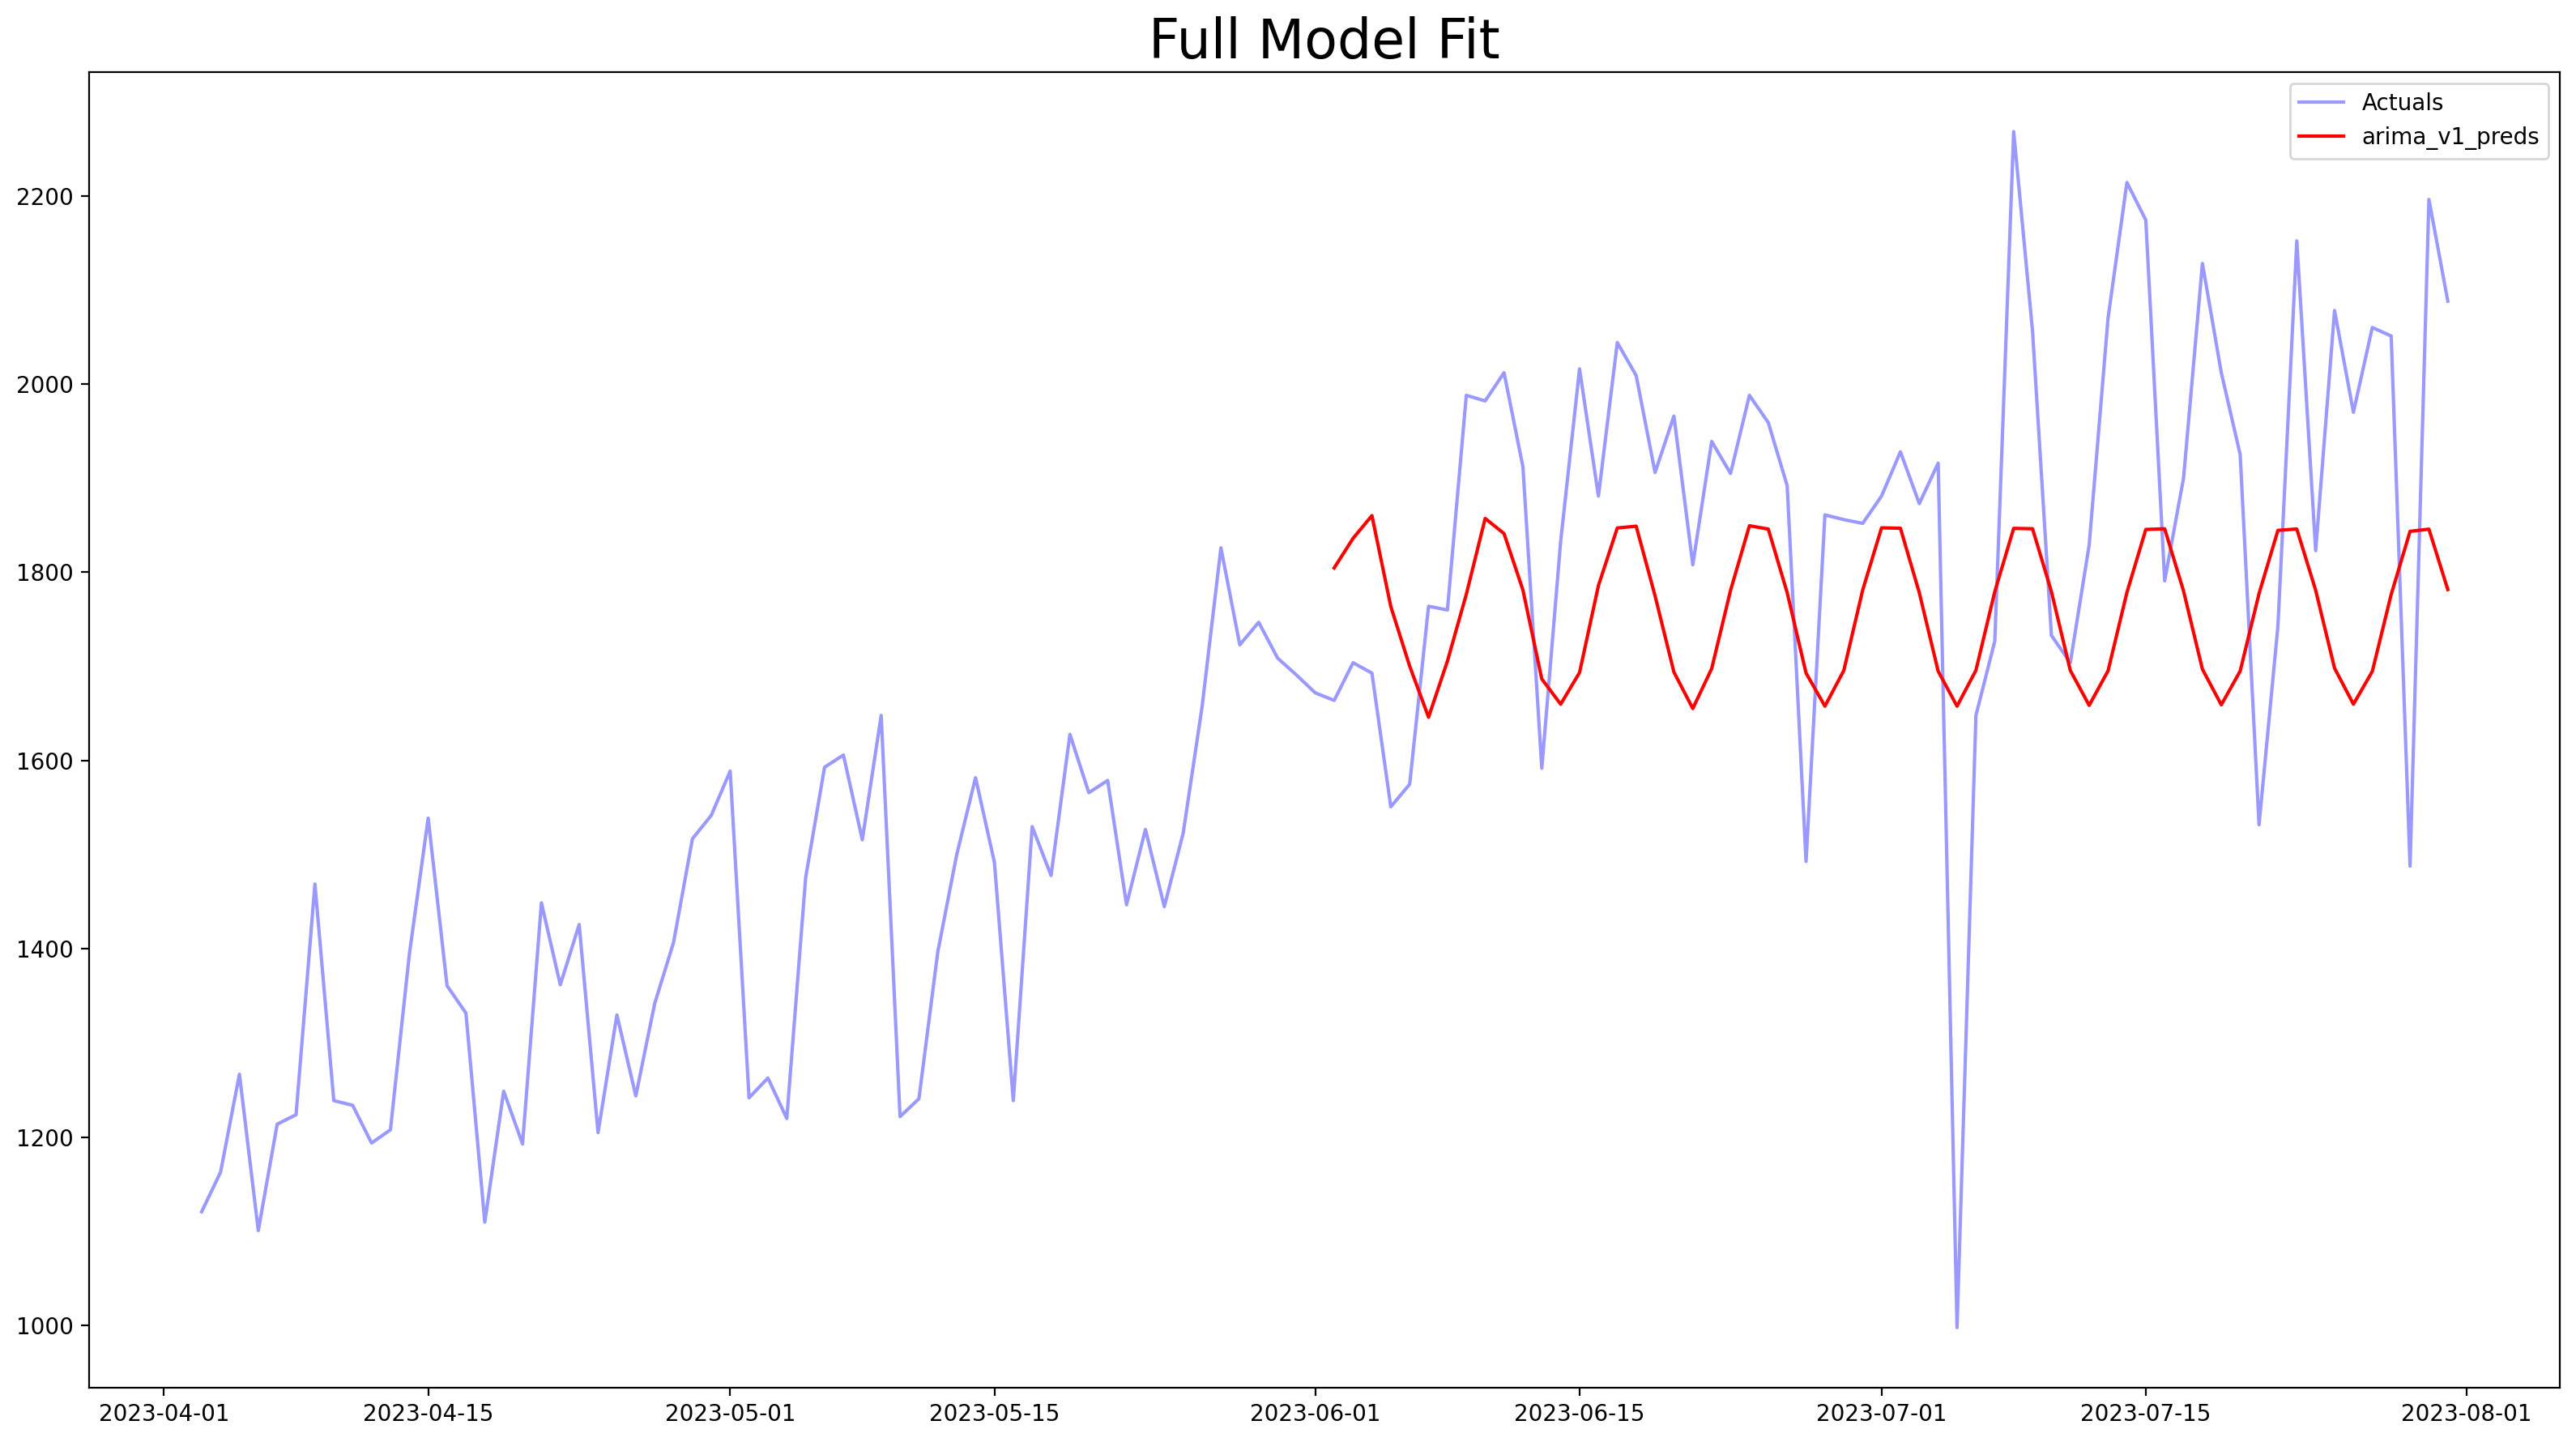

In [291]:
plot_df = pred_df.tail(test_period * 2)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(plot_df['Orders'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    plot_df.loc[test_df.index]['arima_v1_preds'],
    color='red',
    label='arima_v1_preds',
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [292]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    max_d=3,
    max_p=8,
    max_q=8,
    test='adf',
    error_action='ignore',
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17870.530, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18094.579, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17973.371, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17925.036, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18092.707, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17881.275, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17881.278, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17865.377, Time=1.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17850.330, Time=0.68 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17905.484, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17840.888, Time=0.54 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=17862.187, Time=0.41 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=17835.114, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=17837.901, Time=0.46 sec
 ARIMA(6,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1453
Model:               SARIMAX(8, 1, 0)   Log Likelihood               -8882.288
Date:                Sun, 08 Oct 2023   AIC                          17782.575
Time:                        13:41:12   BIC                          17830.102
Sample:                    06-10-2019   HQIC                         17800.309
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4096      0.019    -22.124      0.000      -0.446      -0.373
ar.L2         -0.2359      0.020    -11.712      0.000      -0.275      -0.196
ar.L3         -0.2730      0.022    -12.457      0.000      -0.316      -0.230
ar.L4         -0.1939      0.025     -7.728      0.000      -0.243      -0.145
ar.L5         -0.1030      0.024     -4.332      0.000      -0.150      -0.056
ar.L6         -0.0213      0.026     -0.820      0.412      -0.072       0.030
ar.L7          0.1148      0.024      4.852      0.000       0.068       0.161
ar.L8          0.1828      0.021      8.804      0.000       0.142       0.224
sigma2      1.204e+04    275.318     43.736      0.000    1.15e+04    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1092.31
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [294]:
arima_model = ARIMA(train_df['Orders'], order=(8, 1, 0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Orders   No. Observations:                 1453
Model:                 ARIMA(8, 1, 0)   Log Likelihood               -8882.288
Date:                Sun, 08 Oct 2023   AIC                          17782.575
Time:                        13:41:34   BIC                          17830.102
Sample:                    06-10-2019   HQIC                         17800.309
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4096      0.019    -22.124      0.000      -0.446      -0.373
ar.L2         -0.2359      0.020    -11.712      0.000      -0.275      -0.196
ar.L3         -0.2730      0.022    -12.457      0.0

In [295]:
pred_df['arima_v2_preds'] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

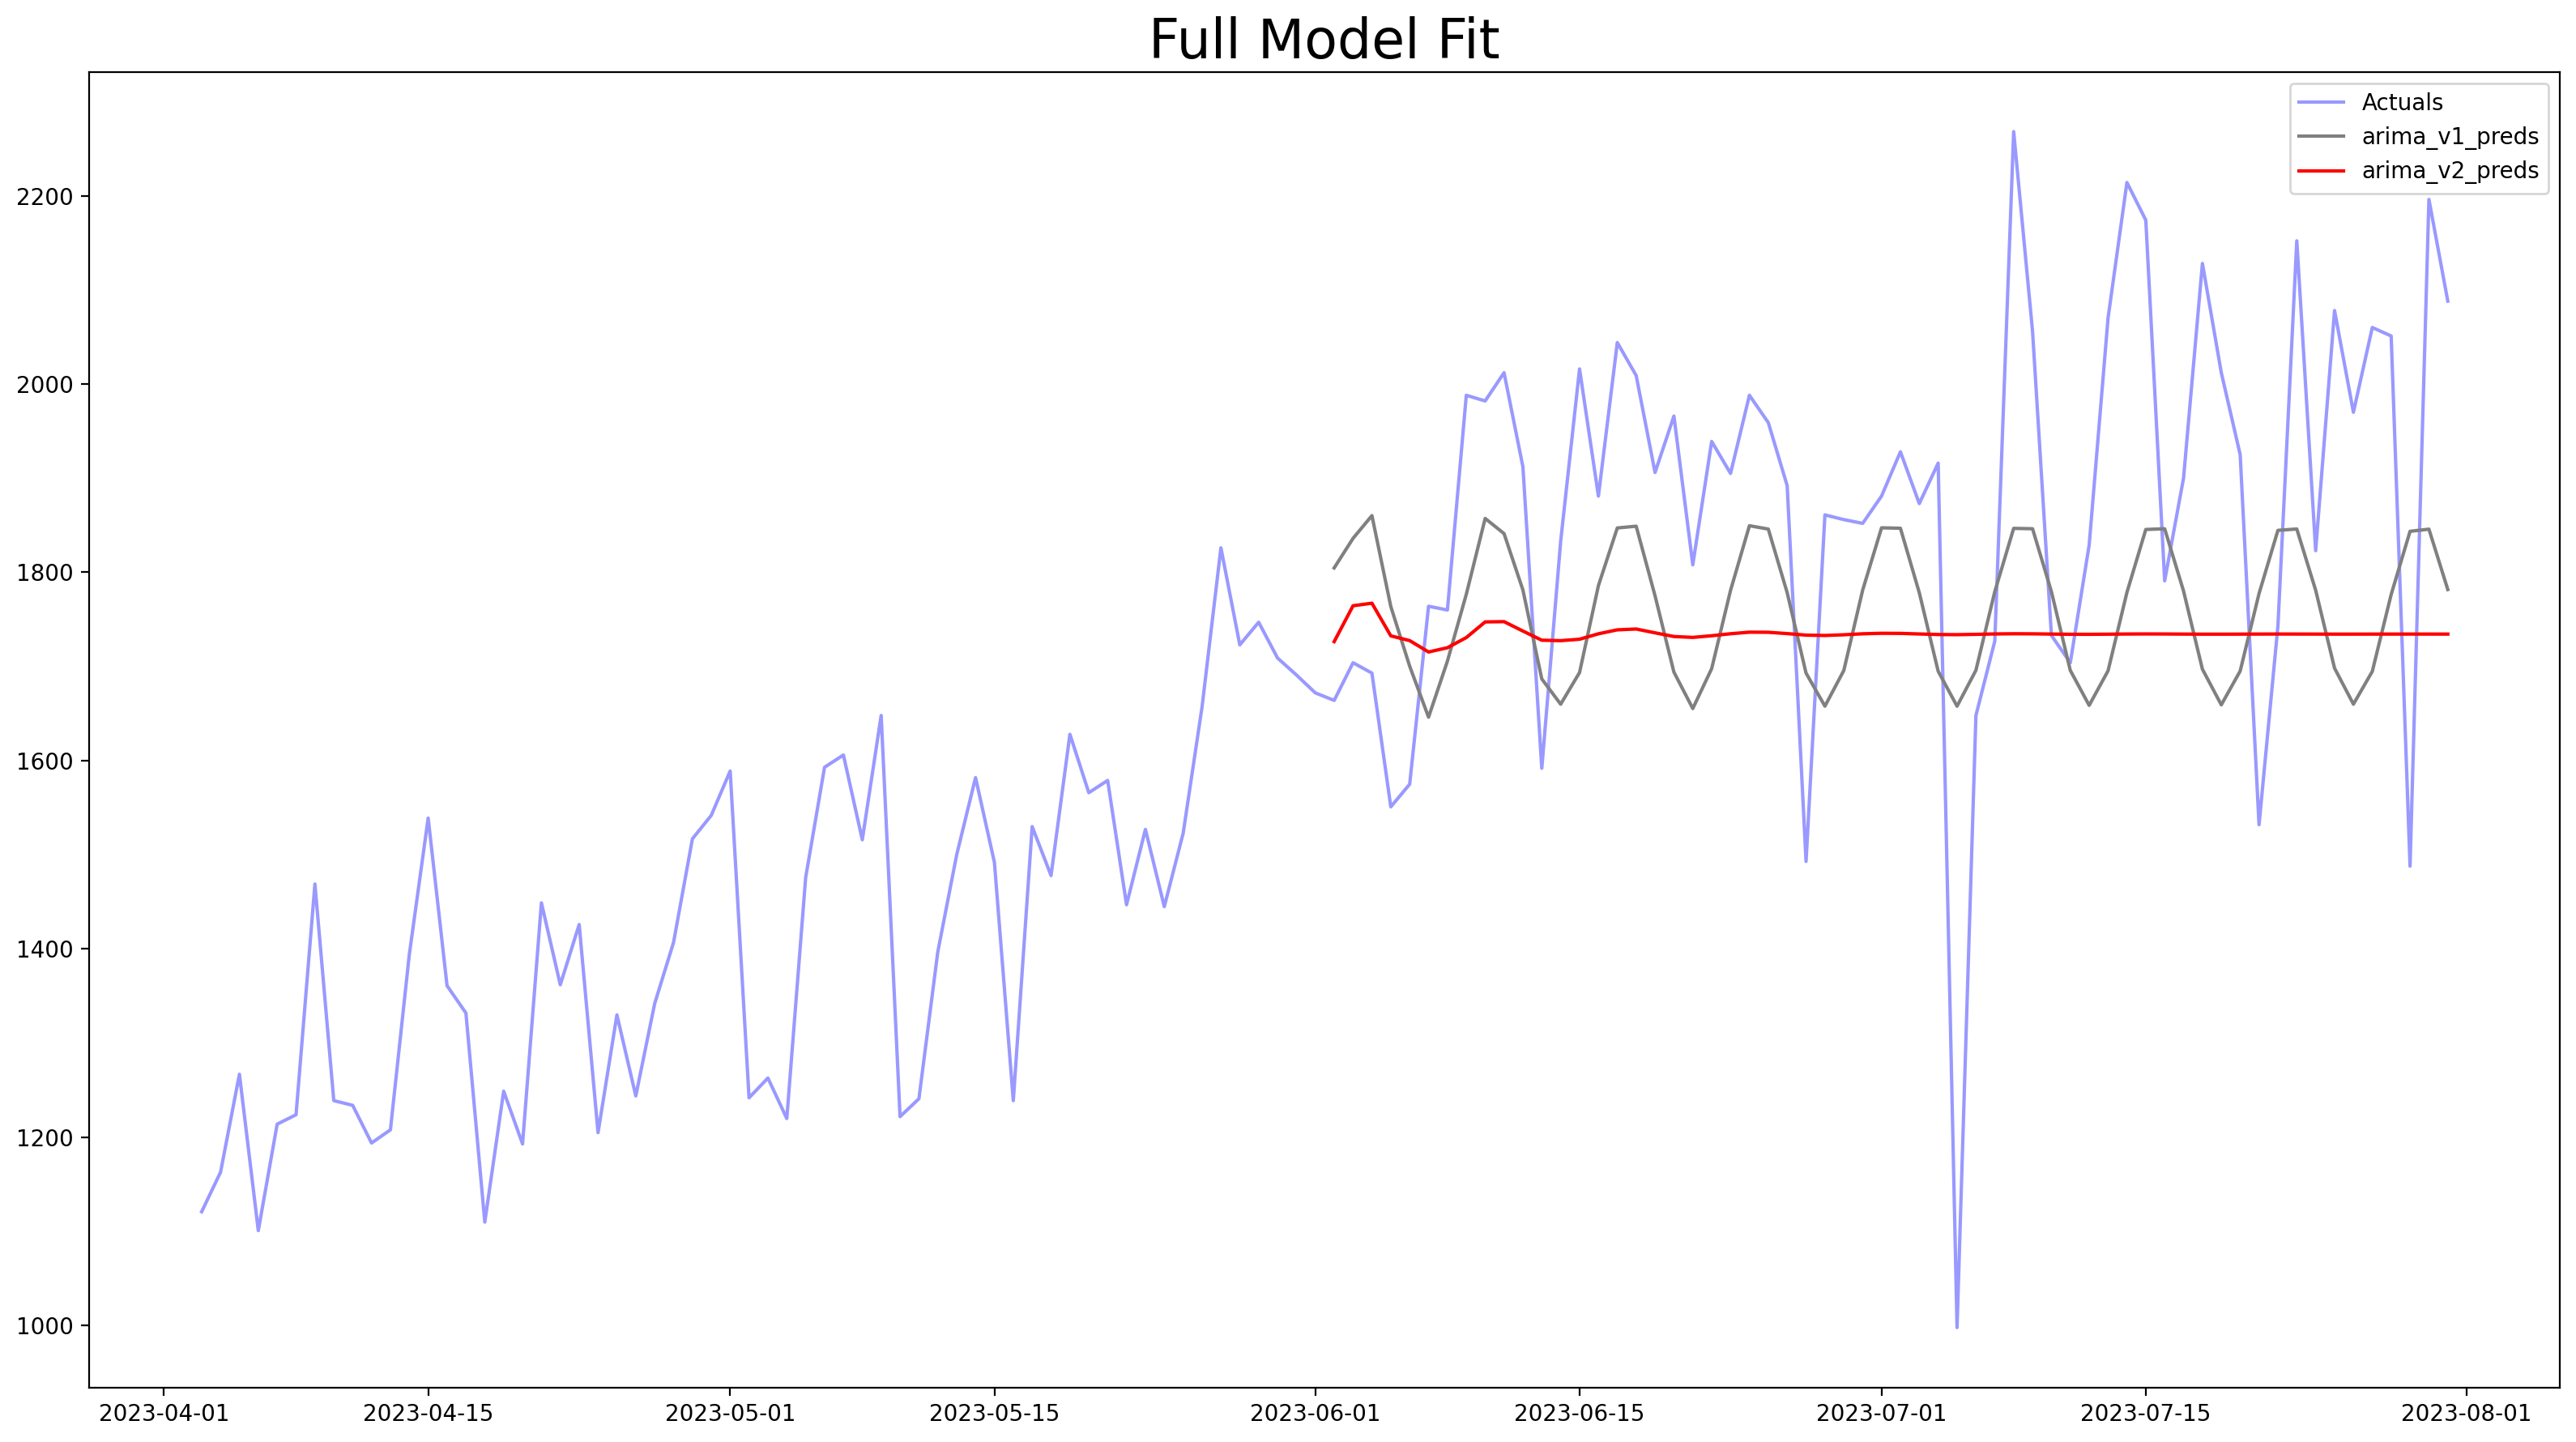

In [297]:
plot_df = pred_df.tail(test_period * 2)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(plot_df['Orders'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    plot_df.loc[test_df.index]['arima_v1_preds'],
    color='gray',
    label='arima_v1_preds',
)
ax.plot(
    plot_df.loc[test_df.index]['arima_v2_preds'],
    color='red',
    label='arima_v2_preds',
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [298]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [299]:
model = pm.auto_arima(train_df,
                      seasonal=True,
                      stepwise=True,
                      # p=7, d=1, q=4,
                      start_p=1, start_d=0, start_q=0,
                      max_p=7, max_d=1, max_q=4,
                      start_P=0, start_D=0, start_Q=0, #start_m=1,
                      max_P=10, max_D=5, max_Q=5, #max_m=10,
                      m=7,
                      trace=True,  # print status on the fits
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True)  # don't want convergence warnings
                      
# Output optimal model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=17870.530, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=18094.579, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17934.057, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17891.516, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=18092.707, Time=0.01 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=17814.229, Time=1.38 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=17775.509, Time=2.75 sec
 ARIMA(2,1,2)(3,0,0)[7] intercept   : AIC=17734.608, Time=4.06 sec
 ARIMA(2,1,2)(4,0,0)[7] intercept   : AIC=17713.745, Time=8.70 sec
 ARIMA(2,1,2)(5,0,0)[7] intercept   : AIC=17706.913, Time=16.02 sec
 ARIMA(2,1,2)(6,0,0)[7] intercept   : AIC=17694.855, Time=26.80 sec
 ARIMA(2,1,2)(7,0,0)[7] intercept   : AIC=17676.963, Time=41.57 sec
 ARIMA(2,1,2)(8,0,0)[7] intercept   : AIC=17677.093, Time=59.01 sec
 ARIMA(2,1,2)(7,0,1)[7] intercept   : AIC=inf, Time=41.24 sec
 ARIMA(2,1,2)(6,0,1)

KeyboardInterrupt: 

In [307]:
# p, d, q = 5, 1, 4
# P, D, Q, m = 3, 0, 1, 7

p, d, q = 5, 1, 4
P, D, Q, m = 3, 0, 1, 7

sarima_model = SARIMAX(
    train_df['Orders'], order=(p, d, q), seasonal_order=(P, D, Q, m)
)

sarima_model_fit = sarima_model.fit()
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              Orders   No. Observations:                 1453
Model:             SARIMAX(5, 1, 4)x(3, 0, [1], 7)   Log Likelihood               -8817.031
Date:                             Sun, 08 Oct 2023   AIC                          17662.063
Time:                                     14:57:34   BIC                          17735.993
Sample:                                 06-10-2019   HQIC                         17689.649
                                      - 06-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1700      0.168     -6.947      0.000      -1.500      -0.840
ar.L2         -1.1274      0.221     -5.112      0.000      -1.560      -0.695
ar.L3         -0.8829      0.167     -5.277      0.000      -1.211      -0.555
ar.L4         -0.1168      0.175     -0.669      0.504      -0.459       0.226
ar.L5         -0.0824      0.066     -1.253      0.210      -0.211       0.047
ma.L1          0.7365      0.168      4.377      0.000       0.407       1.066
ma.L2          0.5763      0.162      3.560      0.000       0.259       0.893
ma.L3          0.2626      0.107      2.458      0.014       0.053       0.472
ma.L4         -0.3353      0.116     -2.886      0.004      -0.563      -0.108
ar.S.L7        1.0176      0.037     27.198      0.000       0.944       1.091
ar.S.L14       0.0006      0.048      0.013      0.990      -0.093       0.094
ar.S.L21      -0.0300      0.034     -0.878      0.380      -0.097       0.037
ma.S.L7       -0.9180      0.024    -38.804      0.000      -0.964      -0.872
sigma2      1.173e+04    272.918     42.981      0.000    1.12e+04    1.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2456.59
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.56
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [308]:
pred_df['sarima_preds'] = sarima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

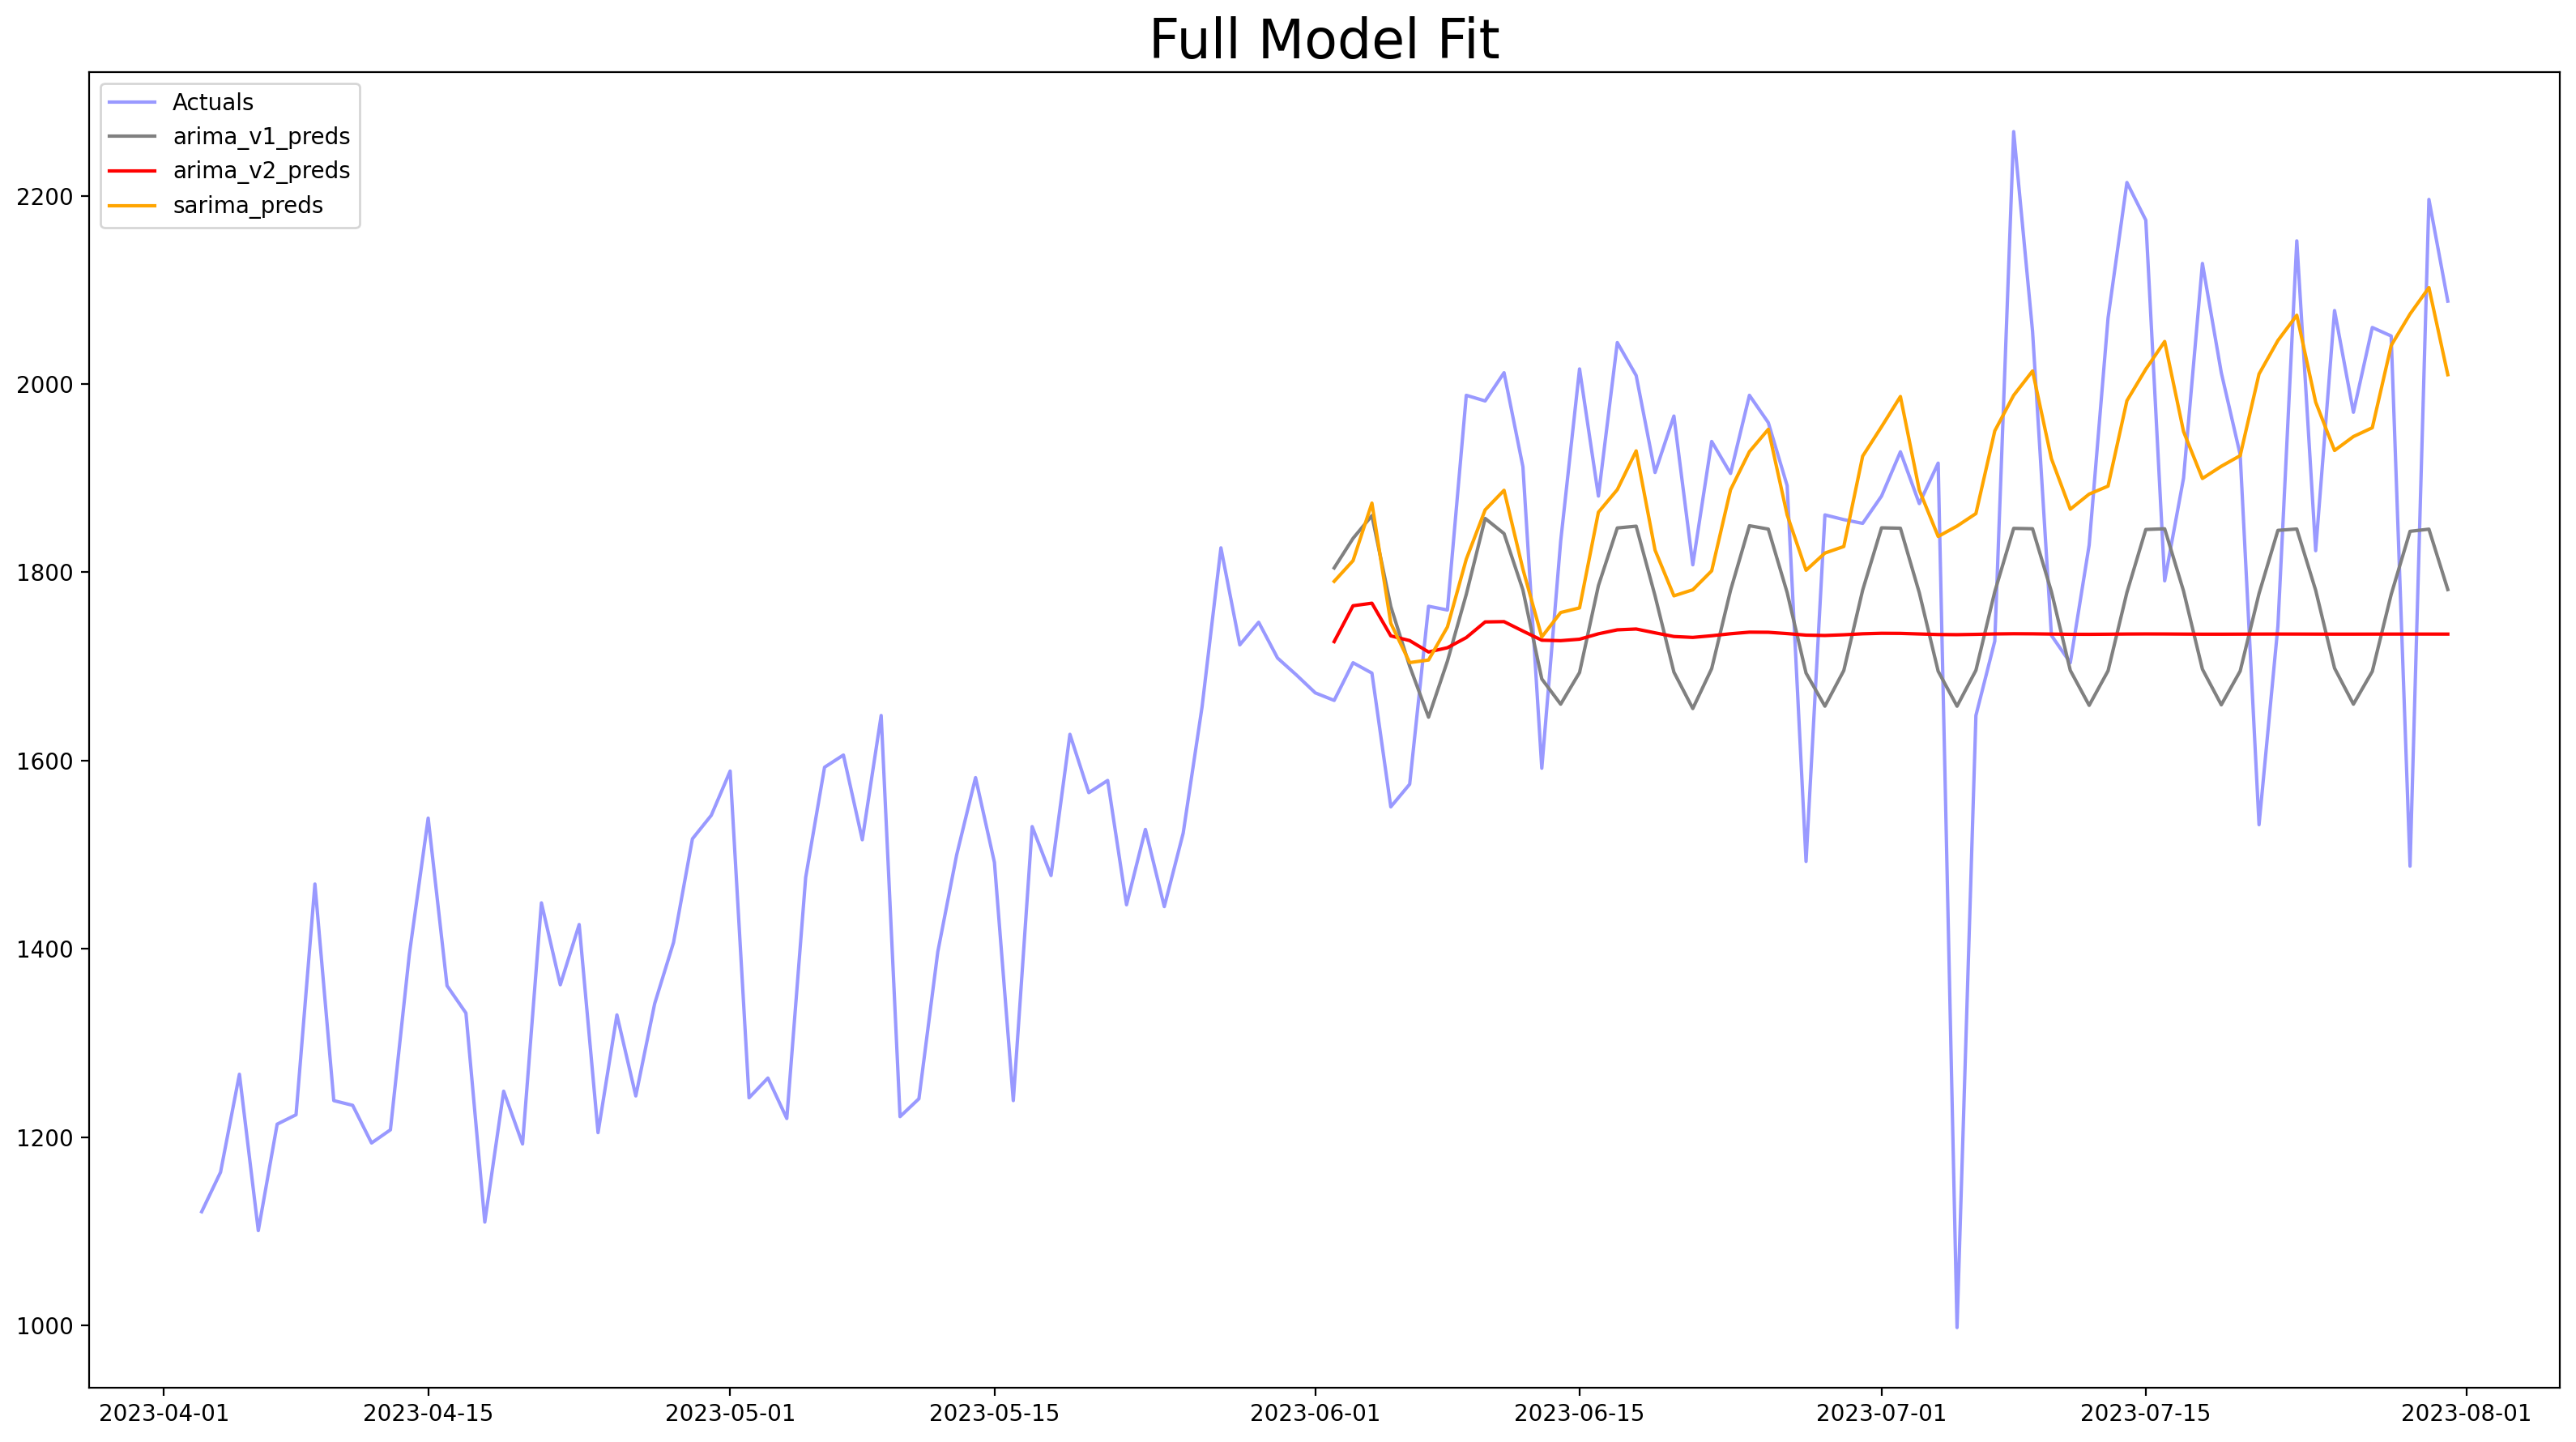

In [310]:
plot_df = pred_df.tail(test_period * 2)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(plot_df['Orders'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    plot_df.loc[test_df.index]['arima_v1_preds'],
    color='gray',
    label='arima_v1_preds',
)
ax.plot(
    plot_df.loc[test_df.index]['arima_v2_preds'],
    color='red',
    label='arima_v2_preds',
)

ax.plot(
    plot_df.loc[test_df.index]['sarima_preds'],
    color='orange',
    label='sarima_preds',
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [321]:
pred_df

,Orders,arima_v1_preds,arima_v2_preds,sarima_preds
2019-06-10,1.0,NaN,NaN,NaN
2019-06-11,14.0,NaN,NaN,NaN
2019-06-12,332.0,NaN,NaN,NaN
2019-06-13,770.0,NaN,NaN,NaN
2019-06-14,840.0,NaN,NaN,NaN
...,...,...,...,...
2023-07-27,2060.0,1694.810001,1734.405466,1953.549365
2023-07-28,2051.0,1776.449260,1734.434040,2040.873705
2023-07-29,1488.0,1843.553968,1734.444525,2074.339450
2023-07-30,2196.0,1845.852293,1734.433585,2102.370078


In [322]:
y_test = test_df['Orders'].values
sarima_pred = pred_df['sarima_preds'].dropna().values
arima_v1_pred = pred_df['arima_v1_preds'].dropna().values
arima_v2_pred = pred_df['arima_v2_preds'].dropna().values

In [324]:
print("mean_squared_error", mean_squared_error(y_test, arima_v1_pred))
print("mean_absolute_error", mean_absolute_error(y_test, arima_v1_pred))

mean_squared_error 55753.96769949758
mean_absolute_error 199.34632604349477


In [325]:
print("mean_squared_error", mean_squared_error(y_test, arima_v2_pred))
print("mean_absolute_error", mean_absolute_error(y_test, arima_v2_pred))

mean_squared_error 64817.354674907794
mean_absolute_error 211.75031243562975


In [323]:
print("mean_squared_error", mean_squared_error(y_test, sarima_pred))
print("mean_absolute_error", mean_absolute_error(y_test, sarima_pred))


mean_squared_error 40768.67150470009
mean_absolute_error 142.85311810232915


In [328]:
df

,Orders
2019-06-10,1.0
2019-06-11,14.0
2019-06-12,332.0
2019-06-13,770.0
2019-06-14,840.0
...,...
2023-07-27,2060.0
2023-07-28,2051.0
2023-07-29,1488.0
2023-07-30,2196.0


In [396]:
window_size = 7
df['Rolling_Mean'] = df['Orders'].rolling(window=window_size).mean()
df['Rolling_Std'] = df['Orders'].rolling(window=window_size).std()

std_num = 1
df['up_boundary'] = df['Rolling_Mean'] + df['Rolling_Std'] * std_num
df['down_boundary'] = df['Rolling_Mean'] - df['Rolling_Std'] * std_num

df['Orders_fix'] = np.where(df['Orders'] > df['up_boundary'], df['Rolling_Mean'], df['Orders'])
df['Orders_fix'] = np.where(df['Orders'] < df['down_boundary'], df['Rolling_Mean'], df['Orders'])


df['Outlier'] = (df['Orders'] > df['Rolling_Mean'] + std_num * df['Rolling_Std']) | (df['Orders'] < df['Rolling_Mean'] - std_num * df['Rolling_Std'])

local_outliers = df[df['Outlier'] == True]
local_outliers

,Orders,Rolling_Mean,Rolling_Std,Outlier,up_boundary,down_boundary,Orders_fix
2019-06-16,1115.0,574.142857,454.876331,True,1029.019188,119.266526,1115.000000
2019-06-20,1066.0,970.714286,94.730696,True,1065.444982,875.983590,1066.000000
2019-06-22,1148.0,1033.428571,92.739523,True,1126.168094,940.689049,1148.000000
2019-06-24,1214.0,1079.000000,96.807369,True,1175.807369,982.192631,1214.000000
2019-06-28,1273.0,1167.714286,65.880483,True,1233.594769,1101.833802,1273.000000
...,...,...,...,...,...,...,...
2023-07-14,2214.0,1982.000000,227.864726,True,2209.864726,1754.135274,2214.000000
2023-07-21,1532.0,1923.142857,217.479829,True,2140.622687,1705.663028,1923.142857
2023-07-23,2152.0,1913.142857,218.906699,True,2132.049556,1694.236158,2152.000000
2023-07-29,1488.0,1946.000000,227.064602,True,2173.064602,1718.935398,1946.000000


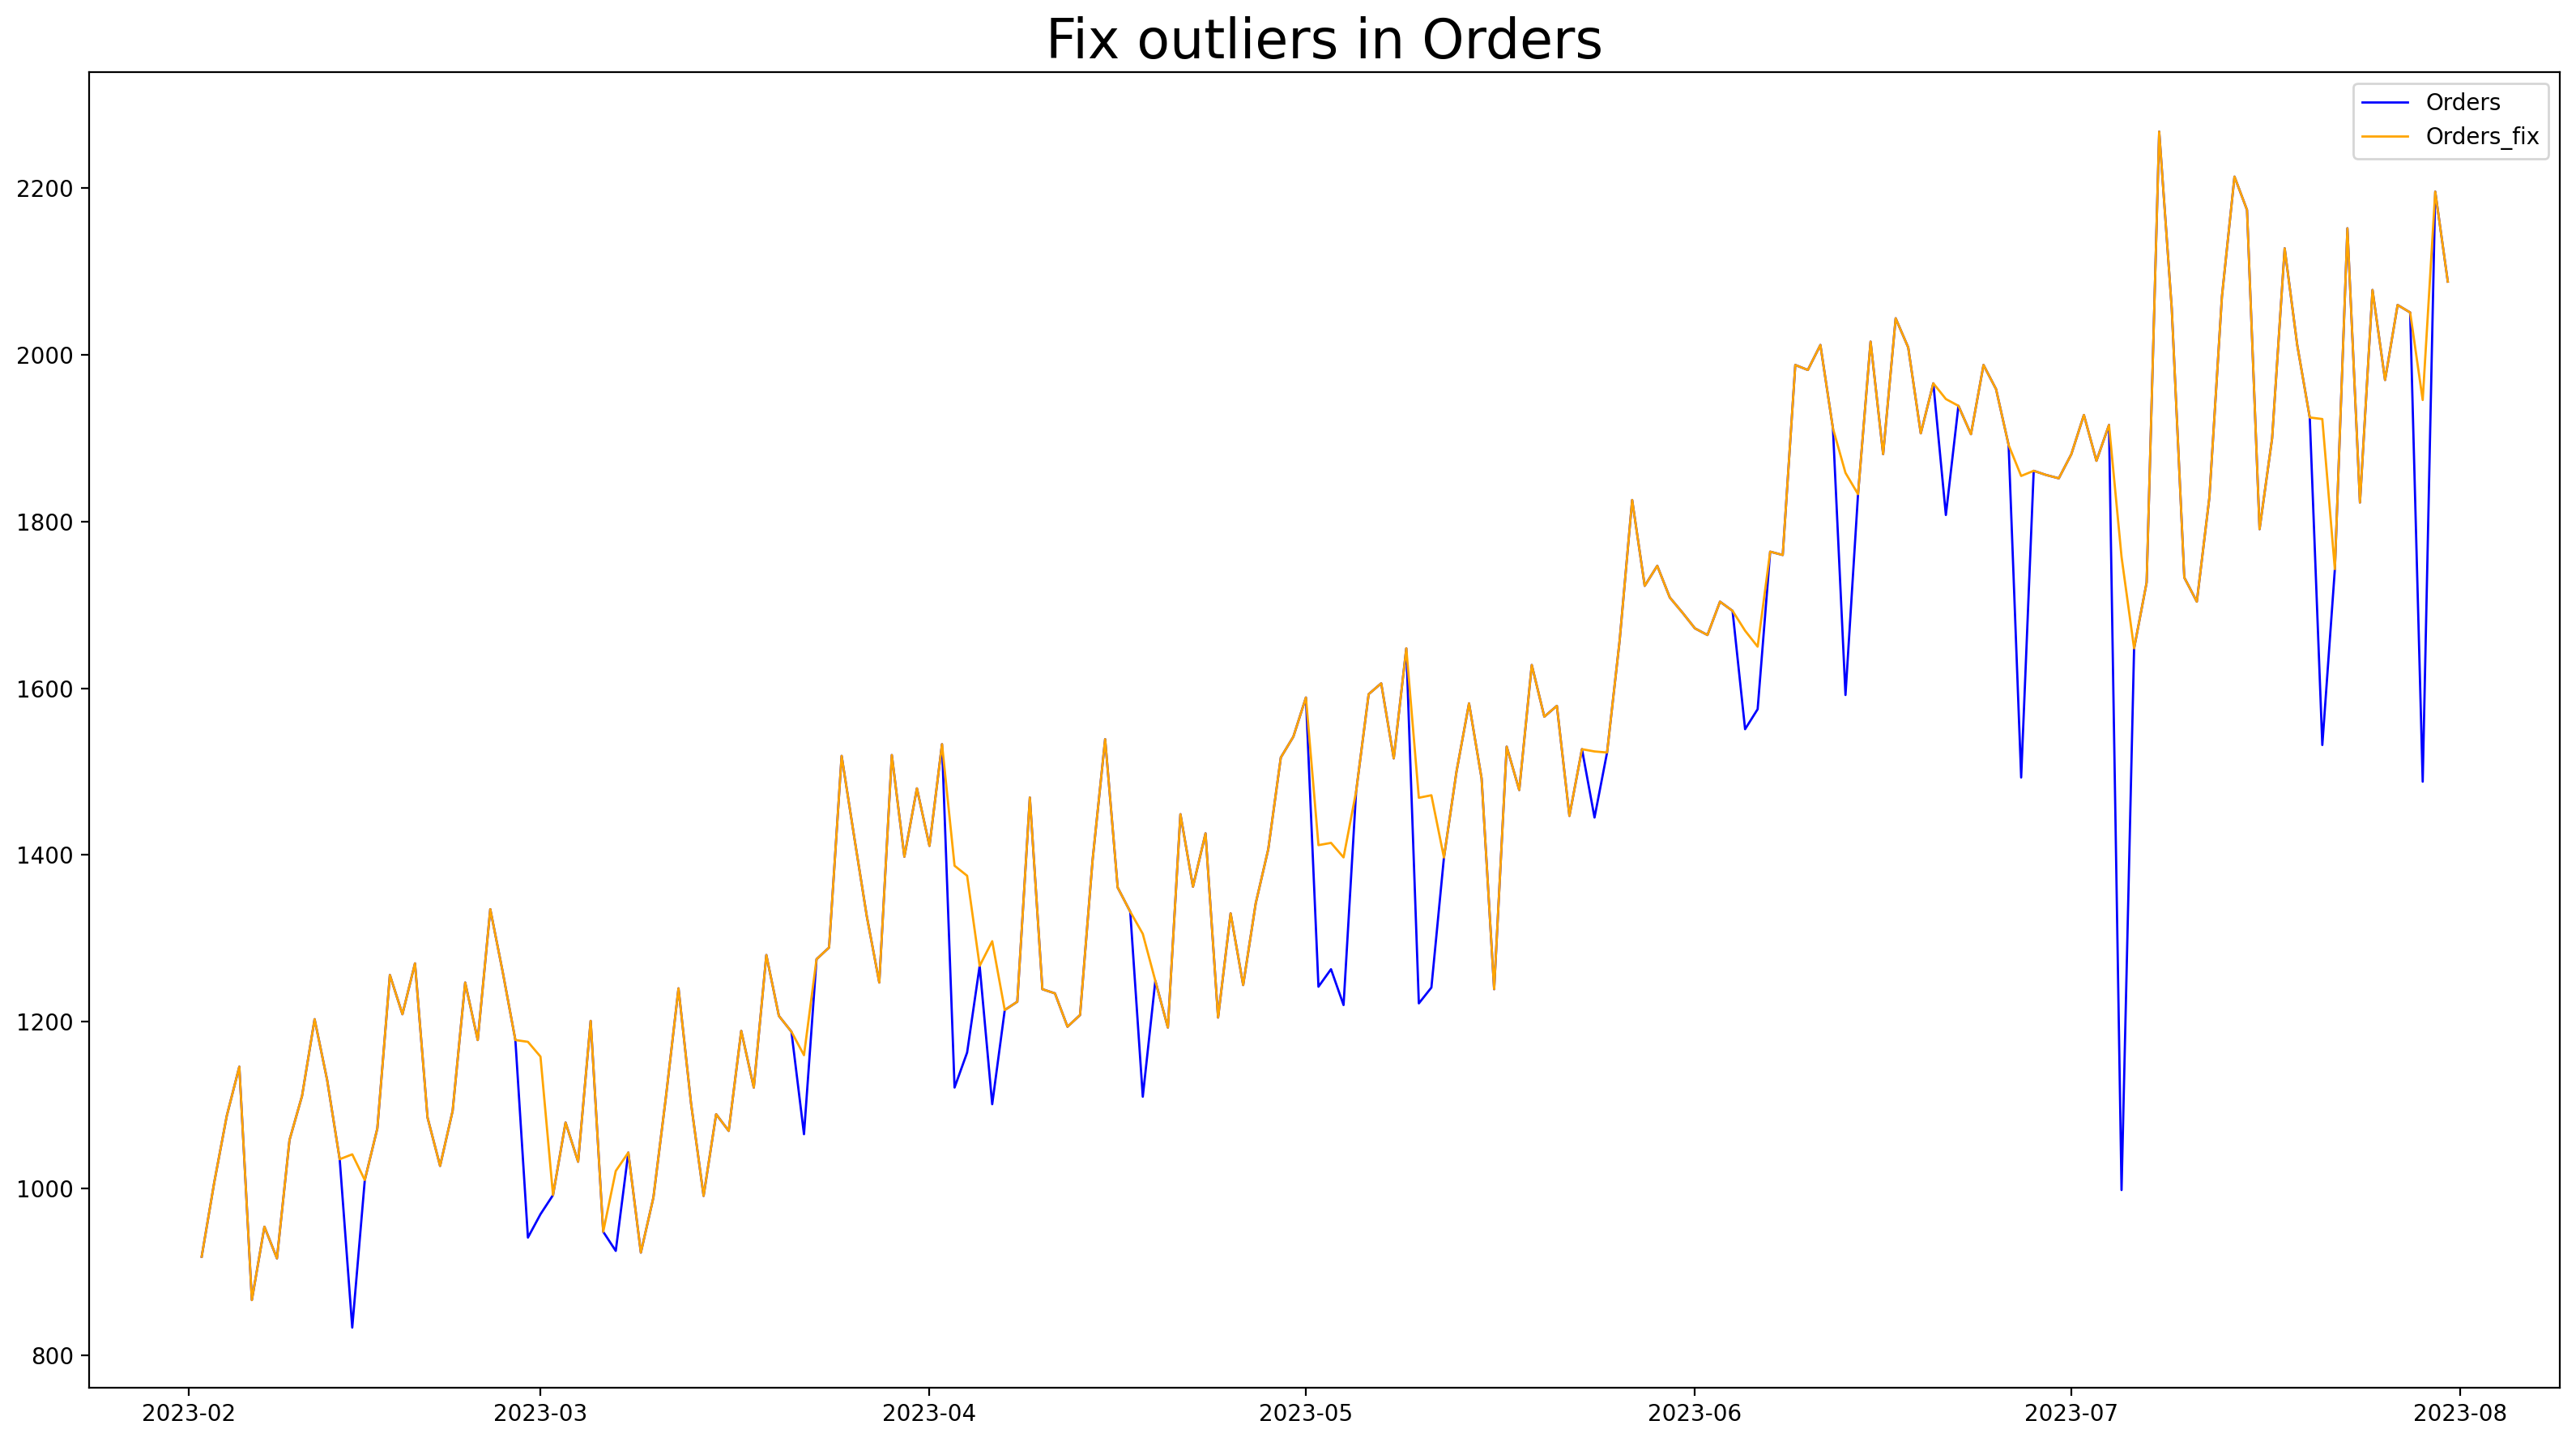

In [397]:
plot_df = df.tail(180)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(plot_df['Orders'], color='blue', label='Orders', linewidth=1)
ax.plot(plot_df['Orders_fix'], color='orange', label='Orders_fix', linewidth=1)

plt.title('Fix outliers in Orders', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [398]:
test_period = 60 # последний месяц оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

In [399]:
p, d, q = 5, 1, 4
P, D, Q, m = 3, 0, 1, 7

sarima_model = SARIMAX(
    train_df['Orders_fix'], order=(p, d, q), seasonal_order=(P, D, Q, m)
)

sarima_model_fit = sarima_model.fit()
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Orders_fix   No. Observations:                 1453
Model:             SARIMAX(5, 1, 4)x(3, 0, [1], 7)   Log Likelihood               -8445.220
Date:                             Sun, 08 Oct 2023   AIC                          16918.440
Time:                                     15:46:28   BIC                          16992.369
Sample:                                 06-10-2019   HQIC                         16946.026
                                      - 06-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7685      0.092     -8.373      0.000      -0.948      -0.589
ar.L2          0.0458      0.045      1.007      0.314      -0.043       0.135
ar.L3         -0.5209      0.049    -10.659      0.000      -0.617      -0.425
ar.L4         -1.0394      0.080    -13.021      0.000      -1.196      -0.883
ar.L5         -0.3395      0.034     -9.956      0.000      -0.406      -0.273
ma.L1          0.3937      0.092      4.291      0.000       0.214       0.574
ma.L2         -0.2522      0.060     -4.228      0.000      -0.369      -0.135
ma.L3          0.6109      0.062      9.881      0.000       0.490       0.732
ma.L4          0.8135      0.092      8.871      0.000       0.634       0.993
ar.S.L7        0.8901      0.075     11.912      0.000       0.744       1.037
ar.S.L14       0.0352      0.039      0.903      0.366      -0.041       0.112
ar.S.L21      -0.0070      0.034     -0.205      0.838      -0.074       0.060
ma.S.L7       -0.7899      0.065    -12.102      0.000      -0.918      -0.662
sigma2      6847.2312    202.513     33.811      0.000    6450.313    7244.149
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               230.26
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [400]:
pred_df['sarima_fix_preds'] = sarima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

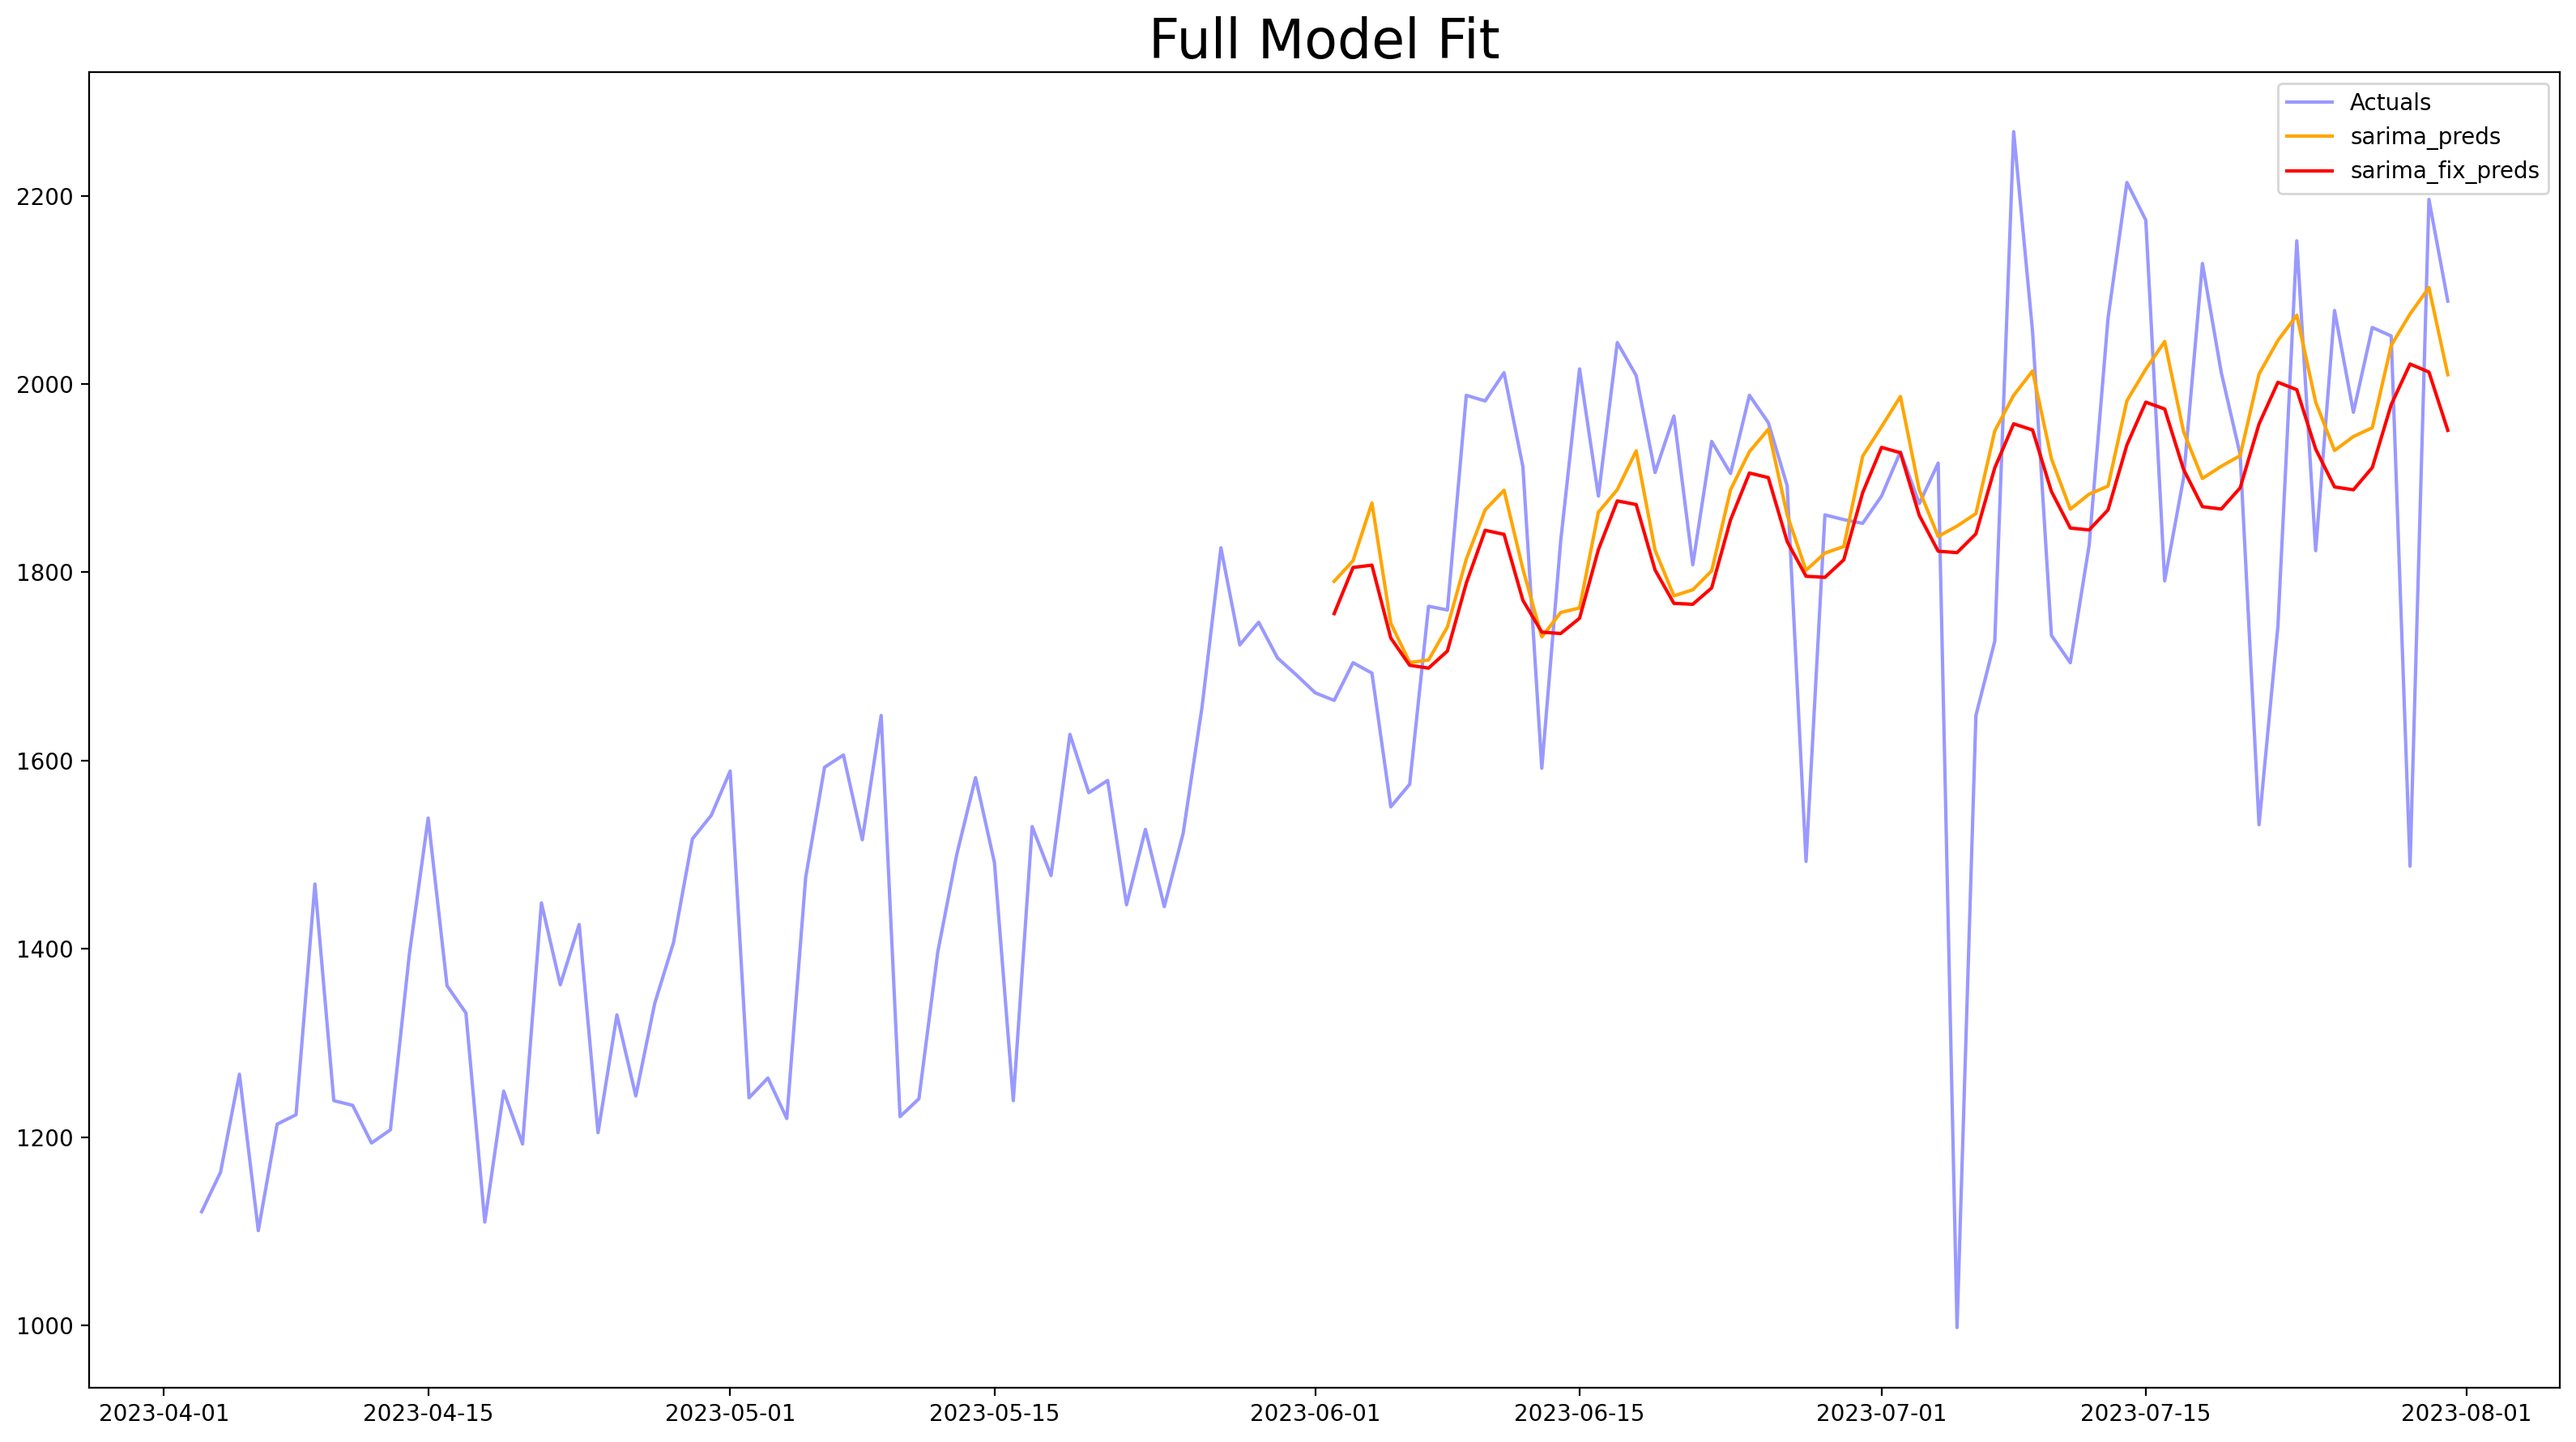

In [401]:
plot_df = pred_df.tail(test_period * 2)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(plot_df['Orders'], color='blue', label='Actuals', alpha=0.4)

ax.plot(
    plot_df.loc[test_df.index]['sarima_preds'],
    color='orange',
    label='sarima_preds',
)

ax.plot(
    plot_df.loc[test_df.index]['sarima_fix_preds'],
    color='red',
    label='sarima_fix_preds',
)

plt.title('Full Model Fit', size=24)
plt.tight_layout()
plt.legend()
plt.show()

In [402]:
y_test = test_df['Orders'].values
sarima_fix_pred = pred_df['sarima_fix_preds'].dropna().values

In [403]:
print("mean_squared_error", mean_squared_error(y_test, sarima_fix_pred))
print("mean_absolute_error", mean_absolute_error(y_test, sarima_fix_pred))

mean_squared_error 40290.20646573019
mean_absolute_error 152.05033623635694
